In [1]:
import os
from collections import defaultdict
import inspect
import pandas as pd
import numpy as np
from scipy import stats
import re
from graphviz import Digraph
import matplotlib.pyplot as plt
import json
from functools import wraps
import seaborn as sns

import sys
sys.path.append('/Users/huangbiao/Documents/github/fairInstrumentation')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize, KBinsDiscretizer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from utils import *
from fairness_instru import *

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',1000)
np.set_printoptions(precision = 4)
pd.set_option("display.precision", 4)
pd.set_option('expand_frame_repr', True)

In [2]:
os.chdir(os.getcwd()+'/../..')

In [3]:
def int_to_string(n):
    return n.to_bytes(math.ceil(n.bit_length() / 8), 'little').decode()

#### functions used to generate matplotlib figures

In [4]:
def autolabel(rects, ax, font_size):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height), fontsize = font_size - 3,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [5]:
def matplotlib_histogram(res, title, pos_group, show_pos, suffix='', export_images=False, save_path = ''):
#     colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    title = title.replace('/','')
    primary_key = remove_list_dup([item[0] for item in res.keys()])
    names = remove_list_dup([item[1] for item in res.keys()])
    
    x = np.arange(len(primary_key))
    width = 0.15
    
    ys_pos, ys_neg = [], []
    for value in res.values():
        neg_group = list(value.keys())[1-list(value.keys()).index(pos_group)]
        ys_pos.append(value[pos_group])
        ys_neg.append(value[neg_group])

    ys_pos = np.array(ys_pos).reshape(2, int(len(ys_pos)/2)).T
    ys_neg = np.array(ys_neg).reshape(2, int(len(ys_neg)/2)).T
    
    if show_pos:
        ys = ys_pos
    else:
        ys = ys_neg
    
    fig, ax = plt.subplots(figsize=(10,6), dpi=100)
    
    rects_pos = [ax.bar(x+i*width, y, width, alpha=0.7, edgecolor='white', label=name) for i, (name, y) in enumerate(zip(names, ys))]

#     you can change the font size HERE
    font_size = 14
    
#     pos_group is the input arguments. Negative group will be infered by the function itself.
    if show_pos:
        ax.set_ylabel(pos_group, fontsize = font_size)
    else:
        ax.set_ylabel(neg_group, fontsize = font_size)
    ax.set_title(title[:40]+' ...'+suffix if len(title)>40 else title+suffix, fontsize = font_size)
    ax.set_xticks(x+width*((len(ys)-1)/2))
    
    ax.set_xticklabels(primary_key, fontsize = font_size)
    ax.legend(fontsize = font_size - 3)
    plt.grid()
    
    for rect in rects_pos:
        autolabel(rect, ax, font_size)
    
    fig.tight_layout() 
    
#     save to png
    if export_images:
        if not os.path.exists(save_path+"/images"):
            os.mkdir(save_path+"/images")
        if show_pos:    
            plt.savefig(save_path+"/images/"+title+suffix+'_pos.png')
        else:
            plt.savefig(save_path+"/images/"+title+suffix+'_neg.png')
    
    plt.show()
    

#### function used for generate images

In [6]:
def plotly_hist_static_label(pos_group, log_list_dag, plot_dict, suffix='', export_images=False, save_path = ''):
    for status in log_list_dag[:-1]:
        plt_titles='INSPECTING ' + int_to_string(int(status))
        to_plot = sort_dict_key(plot_dict[int(status)])
        print("Positive_Lable:")
        matplotlib_histogram(to_plot, plt_titles, pos_group, show_pos = 1, suffix = suffix, export_images = export_images, save_path = save_path)
        print("Negative_Lable:")
        matplotlib_histogram(to_plot, plt_titles, pos_group, show_pos = 0, suffix = suffix, export_images = export_images, save_path = save_path)

#     plots = create_hist_sub_plot(to_plot[::-1], plt_titles[::-1], pos_group)

#### function used for generate LOG dataframes

In [7]:
def log_static_label(log_list_dag, log_dict, plot_dict):
    plot_log_changes = []
    for status in log_list_dag[:-1]:
        print()
        print('-------------------------------------------------------------------------------------------')
        print(int_to_string(int(status)))
        if int(status) in log_dict.keys():
            temp_table = log_dict[int(status)]
            plot_log_changes.append(pd.DataFrame(sort_dict_key(plot_dict[int(status)])))
            if len(plot_log_changes) == 1:
                print('No changes in STATIC LABEL')
            else:
                if plot_log_changes[-1].equals(plot_log_changes[-2]):
                    print('No changes in STATIC LABEL')
                else:
                    print('Changes in STATIC LABEL, show changes in percentage')
                    display(plot_log_changes[-1] - plot_log_changes[-2])

            for key, dataframe in temp_table.items():
                        # print(plot_log_changes[-1])
                        # print()
                        # print(plot_log_changes[-2])
                        # print()

                # tables_to_display.append(pd.DataFrame(plot_dict[int(status)]).to_html(classes = 'table table-striped'))
                num_cat = "NUMERICAL features" if key == 'num' else "CATEGORICAL features"
                print(" -- TARGET changed in "+num_cat)
                display(dataframe)

        else:
            plot_log_changes.append(pd.DataFrame(sort_dict_key(plot_dict[int(status)])))

            if len(plot_log_changes) == 1:
                print('No changes in STATIC LABEL')
            else:
                if plot_log_changes[-1].equals(plot_log_changes[-2]):
                    print('No changes in STATIC LABEL')
                else:
                    print('Changes in STATIC LABEL, show changes in percentage')
                    display(plot_log_changes[-1] - plot_log_changes[-2])
            print('No changes in population')
    

## 1. Run pipelines here. Attach tracer_pdf decorator

In [8]:
@tracer(cat_col = ['race'], numerical_col = ['age'], sensi_atts=['sex', 'race'], 
        target_name = "score_text", training = True, save_path = 'case_outputs/compas')
def compas_pipeline(f_path = 'data/compas_train.csv'):

    data = pd.read_csv(f_path)


#     data = data.drop(columns=['age_cat'])


#     data = data.dropna(subset=['id', 'name','is_recid','days_b_screening_arrest','c_charge_degree','c_jail_out','c_jail_in'])


#     data['age_cat'] = data.apply(lambda row:'<25' if row['age'] < 25 else '>45' if row['age']>45 else '25-45', axis=1)


    data = data[['sex', 'dob','age','c_charge_degree', 'race','score_text','priors_count','days_b_screening_arrest',
                 'decile_score','is_recid','two_year_recid','c_jail_in','c_jail_out']]


    data = data.loc[(data['days_b_screening_arrest'] <= 30)]
    data = data.loc[(data['days_b_screening_arrest'] >= -30)]
    data = data.loc[(data['is_recid'] != -1)]
    data = data.loc[(data['c_charge_degree'] != "O")]
    data = data.loc[(data['score_text'] != 'N/A')]
#     data['c_jail_out'] = pd.to_datetime(data['c_jail_out'])
#     data['c_jail_in'] = pd.to_datetime(data['c_jail_in'])
    
    data = data.replace('Medium', "Low")
    
    labels = LabelEncoder().fit_transform(data['score_text'])
    
    #sklearn pipeline
    impute1_and_onehot = Pipeline([('imputer1', SimpleImputer(strategy='most_frequent')),
                                   ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    impute2_and_bin = Pipeline([('imputer2', SimpleImputer(strategy='mean')),
                                ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform'))])
    featurizer = ColumnTransformer(transformers=[
            ('impute1_and_onehot', impute1_and_onehot, ['is_recid']),
            ('impute2_and_bin', impute2_and_bin, ['age'])
        ])

    pipeline = Pipeline([
        ('features', featurizer),
        ('classifier', LogisticRegression())
    ])
    return pipeline

In [9]:
pipeline = compas_pipeline('data/compas_train.csv')
save_path = 'case_outputs/compas'

## 2. Now load all saved intermediate status

In [10]:
log_dict_train = pickle.load(open(save_path+"/checkpoints/log_dict_train.p", 'rb'))

rand_rgb_train = pickle.load(open(save_path+"/checkpoints/rand_color_train.p", 'rb'))

plot_dict_train = pickle.load(open(save_path+"/checkpoints/plot_dict_train.p", 'rb'))

log_list_dag_train = pickle.load(open(save_path+"/checkpoints/log_list_dag_train.p", 'rb'))

target_df_train = pickle.load(open(save_path+"/checkpoints/target_df_train.p", 'rb'))

#### Change attrs once dataset changes

In [11]:
snesi_atts = ['sex', 'race']
target_name = 'score_text'
pos_group = 'High'


## 3. Generate Histogram

Positive_Lable:


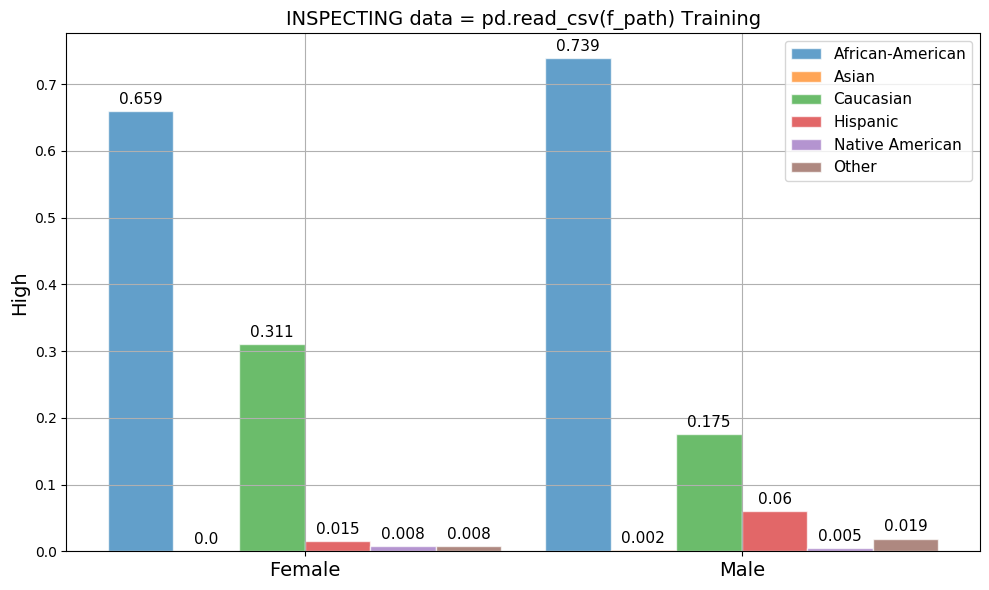

Negative_Lable:


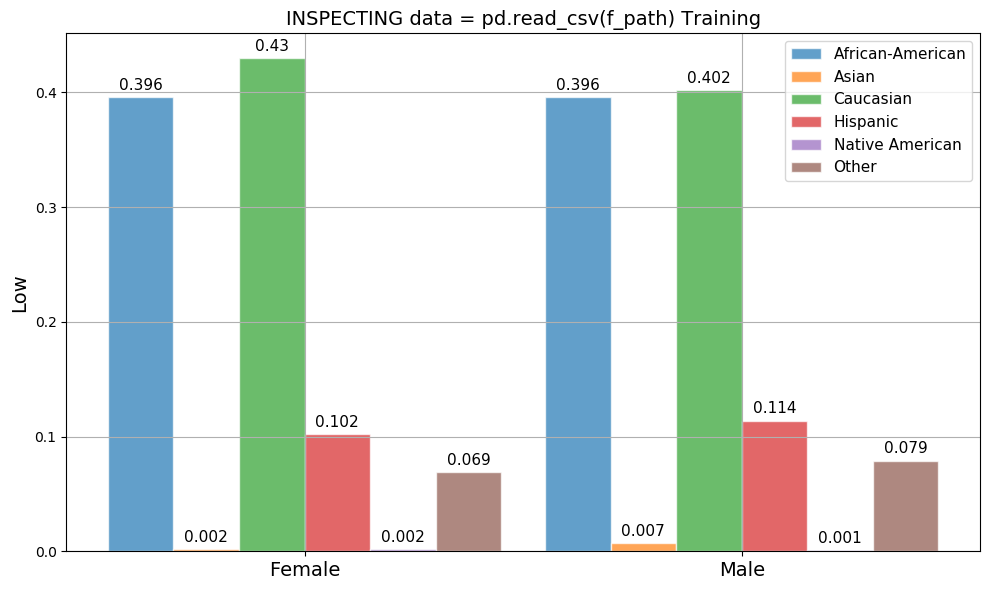

Positive_Lable:


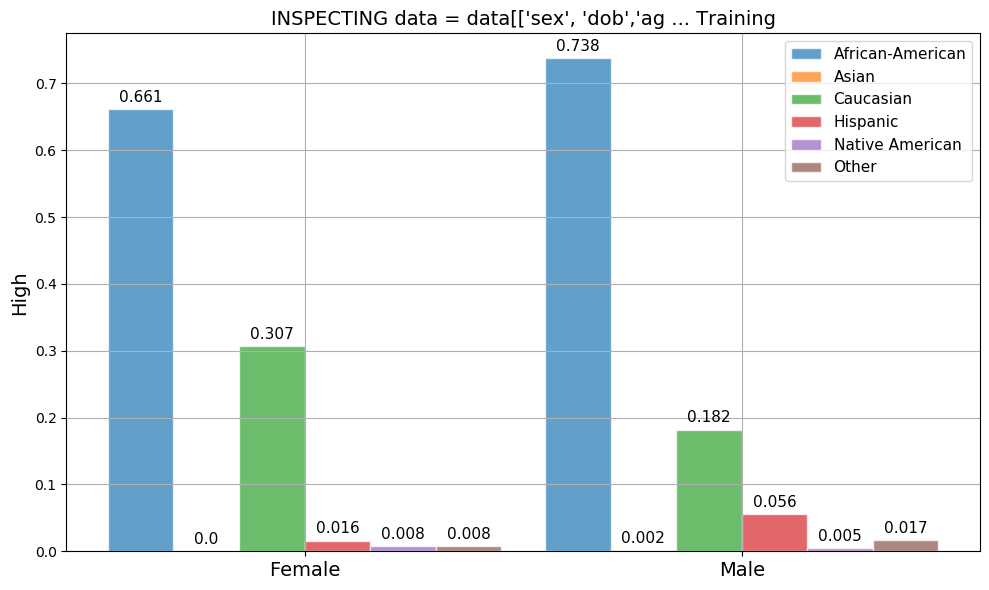

Negative_Lable:


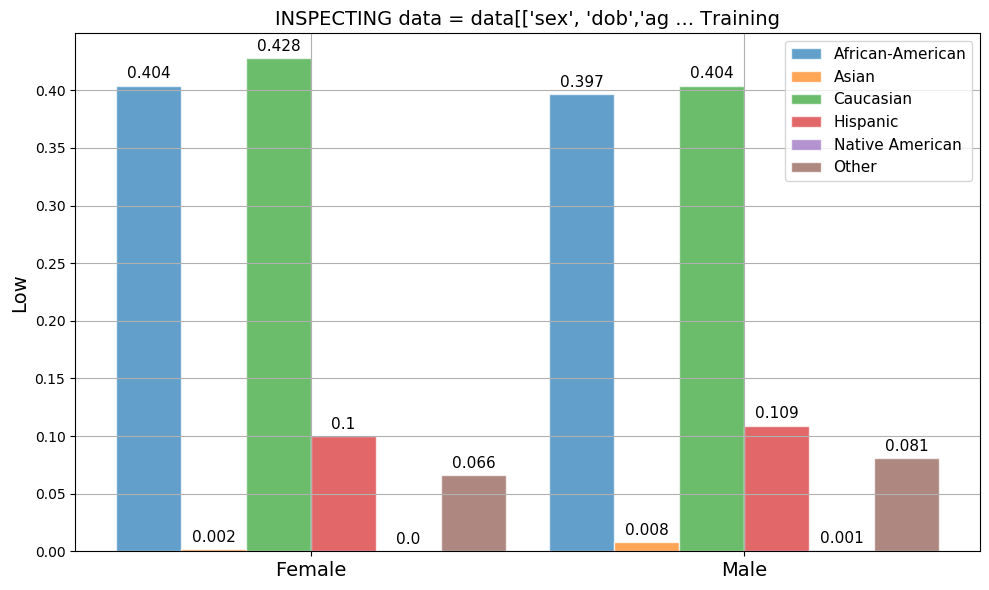

Positive_Lable:


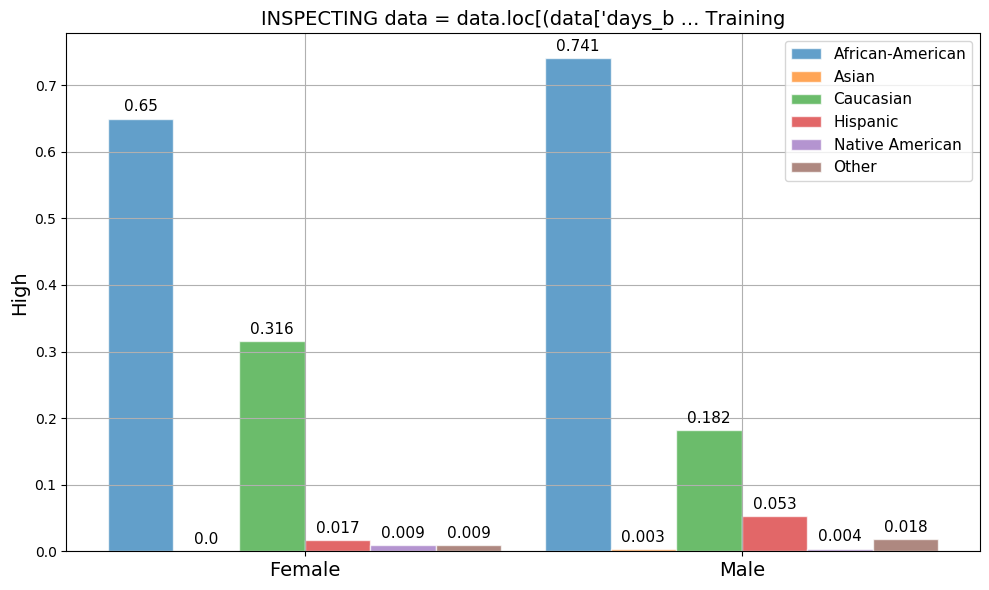

Negative_Lable:


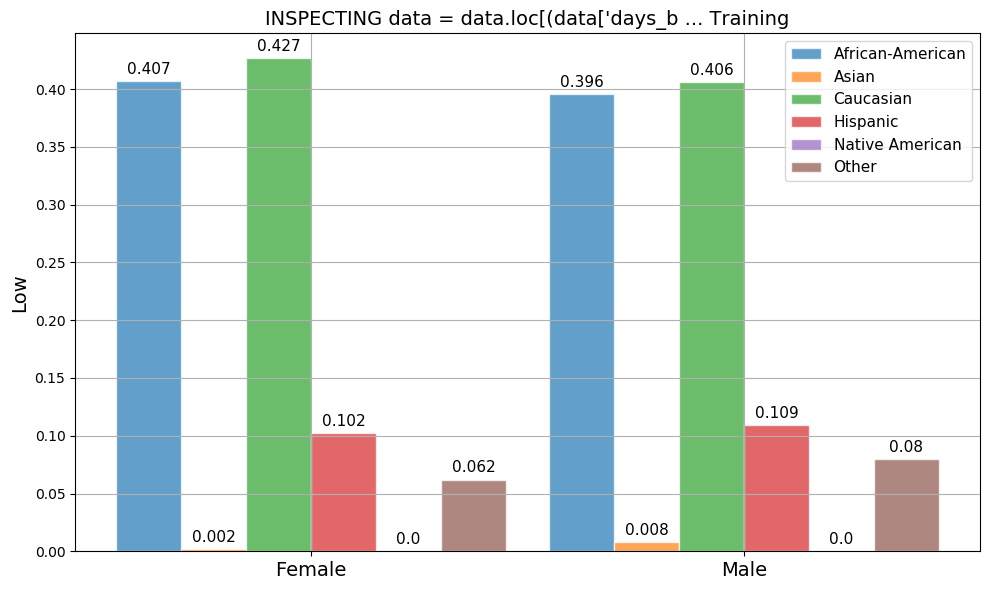

Positive_Lable:


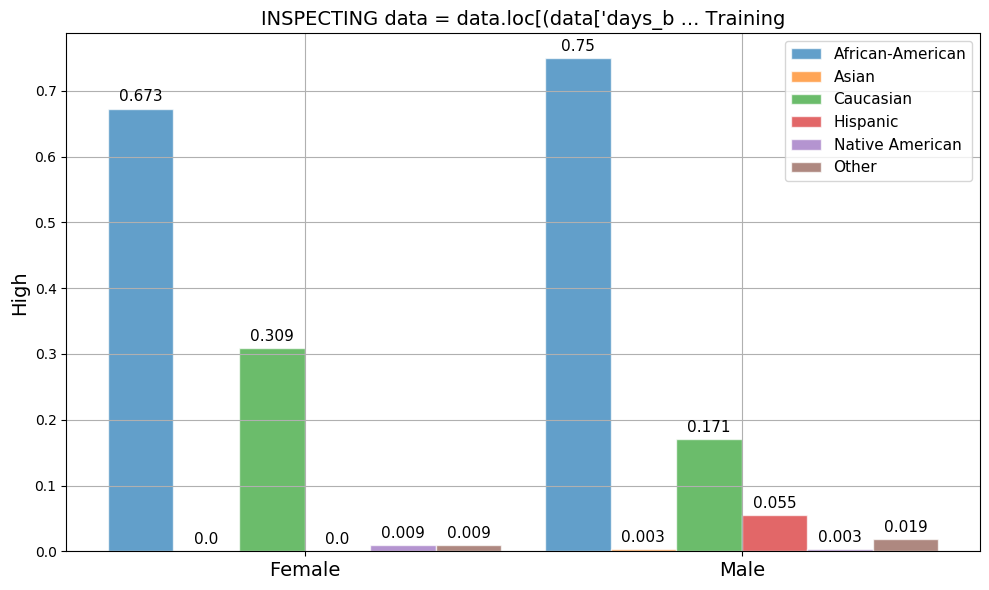

Negative_Lable:


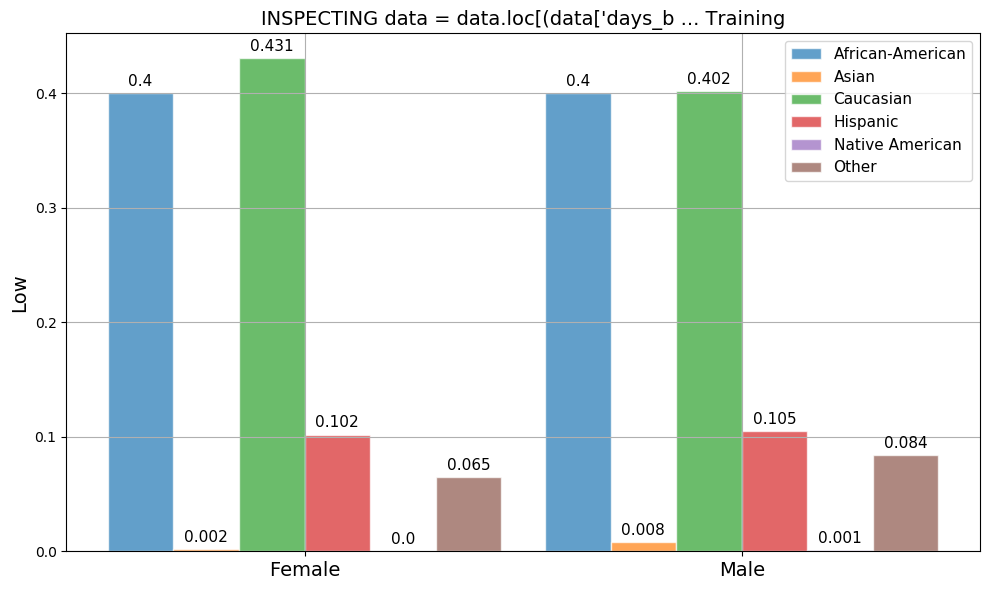

Positive_Lable:


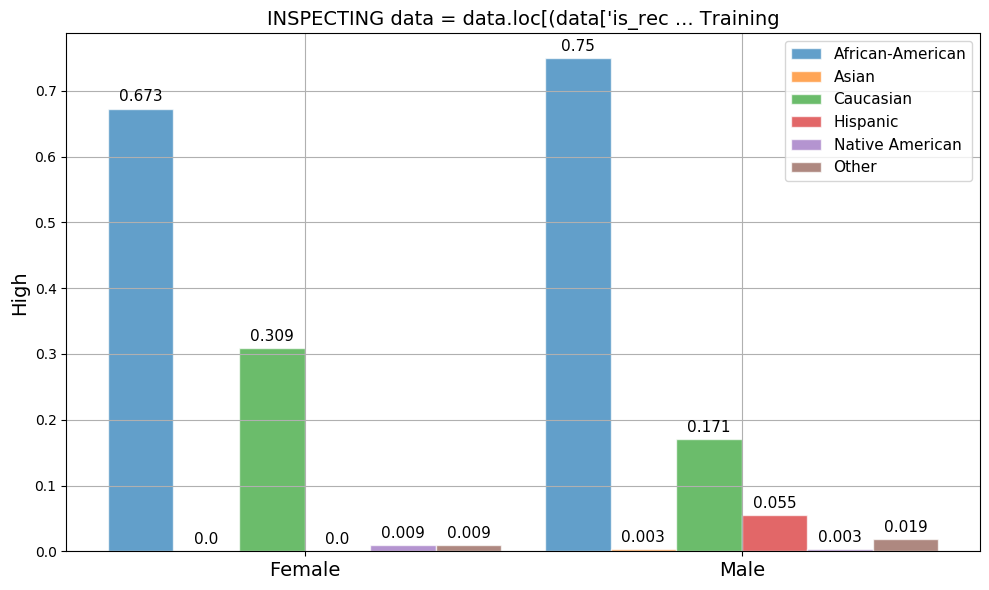

Negative_Lable:


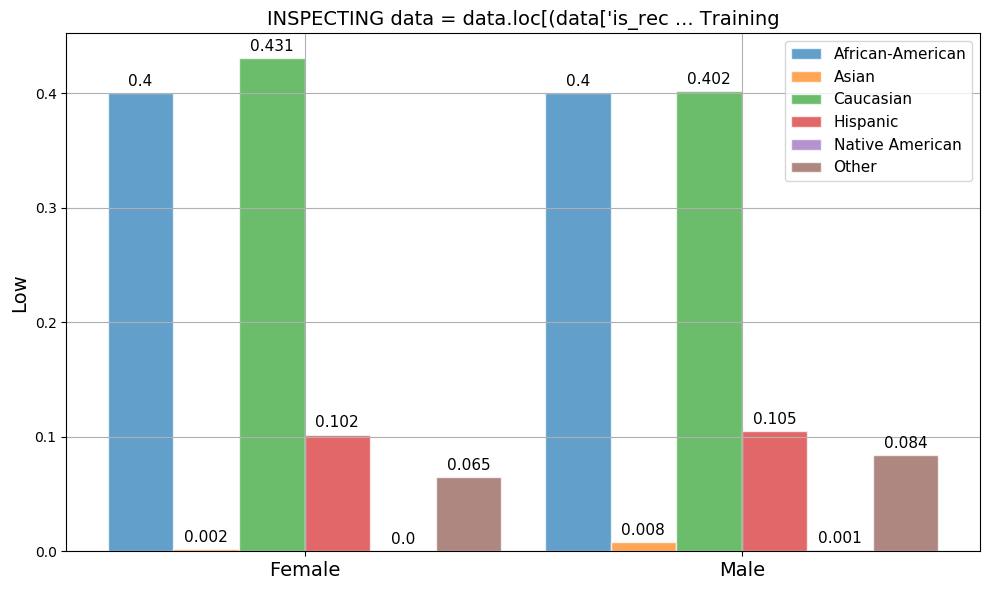

Positive_Lable:


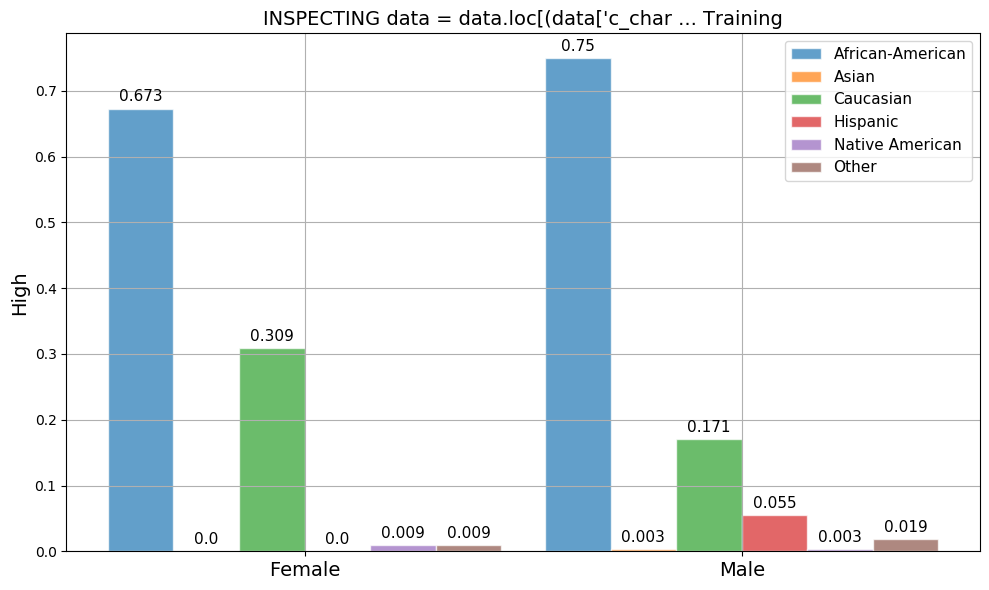

Negative_Lable:


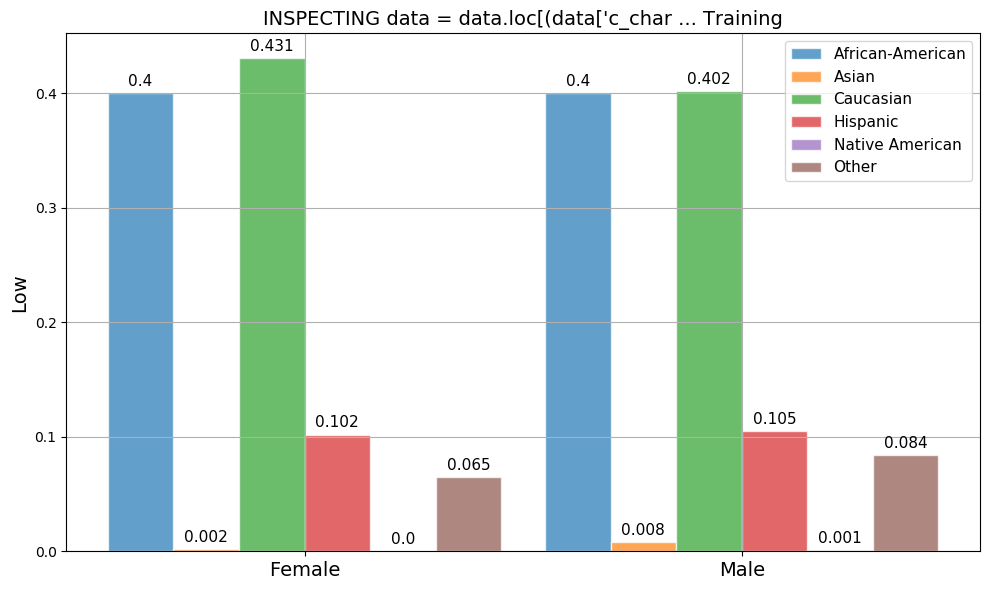

Positive_Lable:


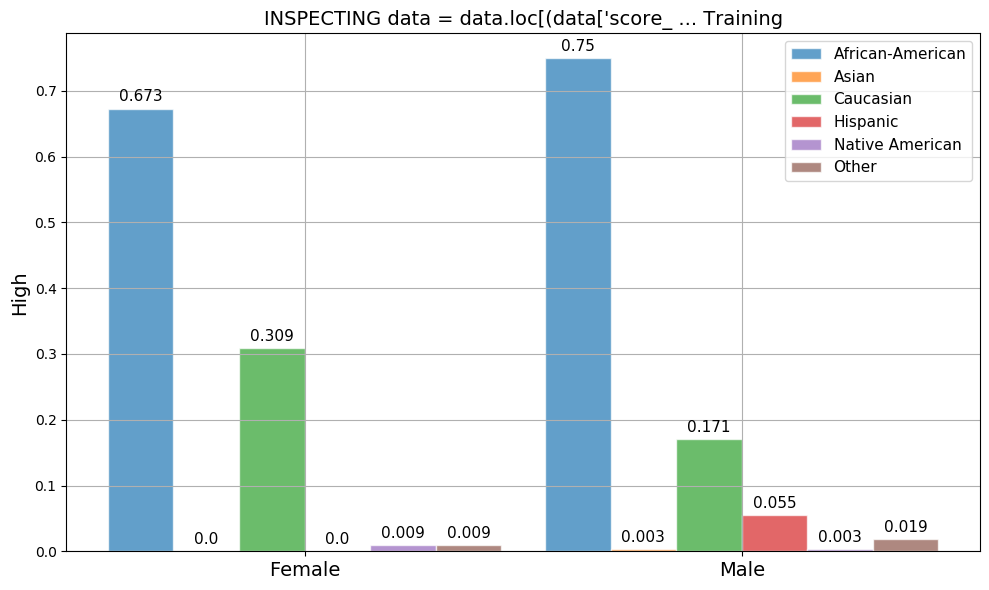

Negative_Lable:


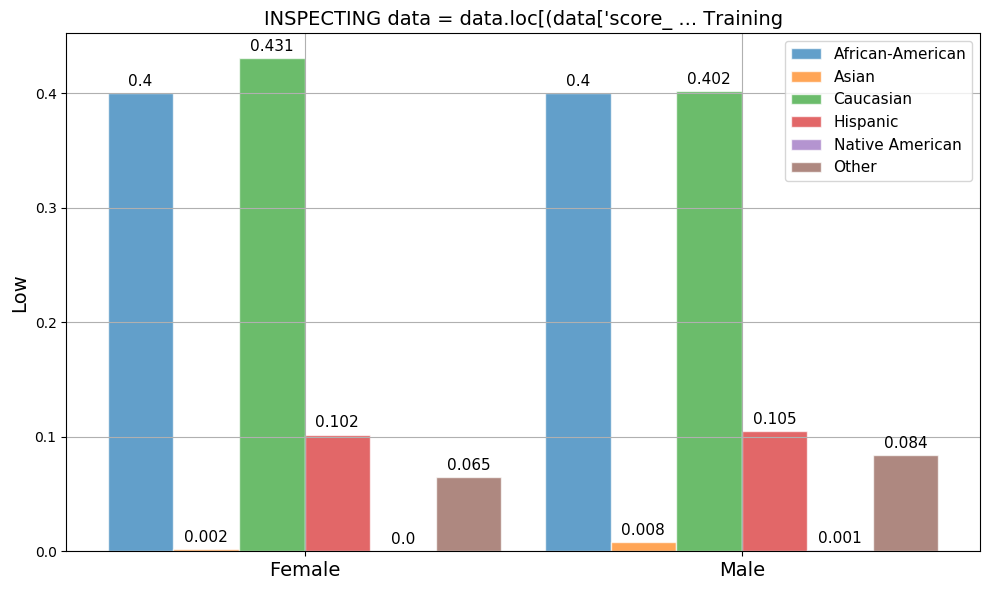

Positive_Lable:


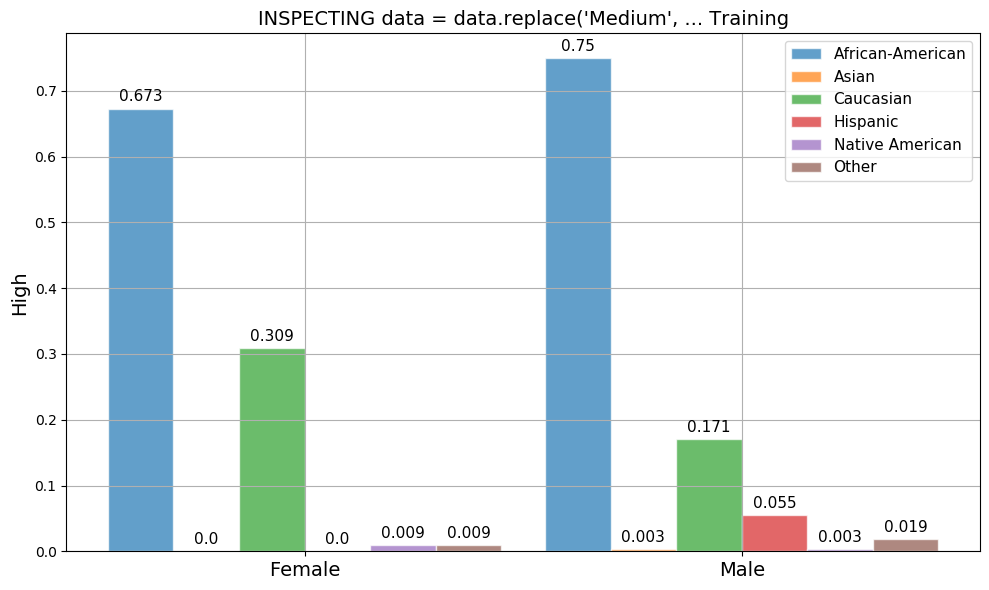

Negative_Lable:


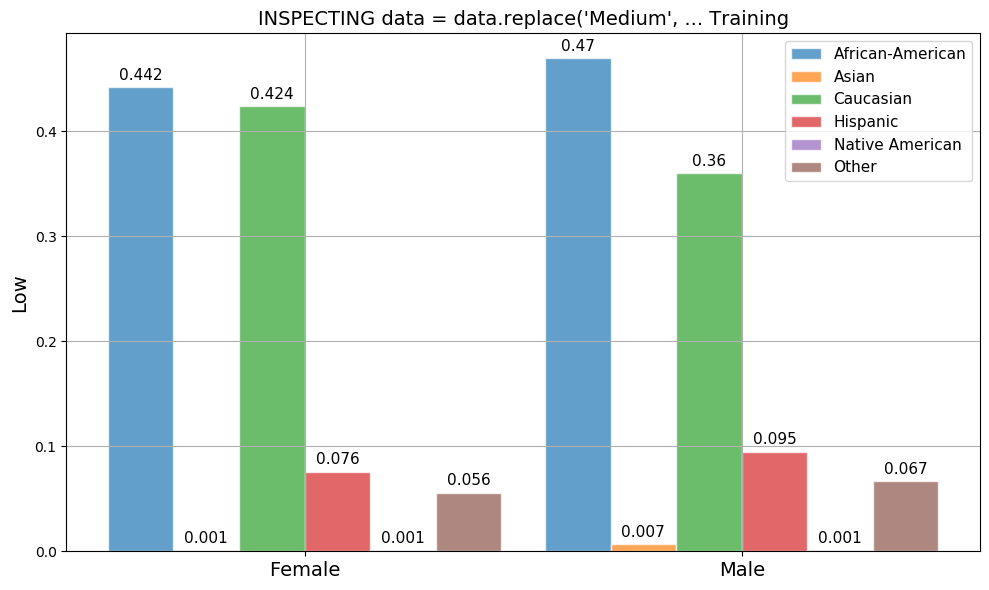

Positive_Lable:


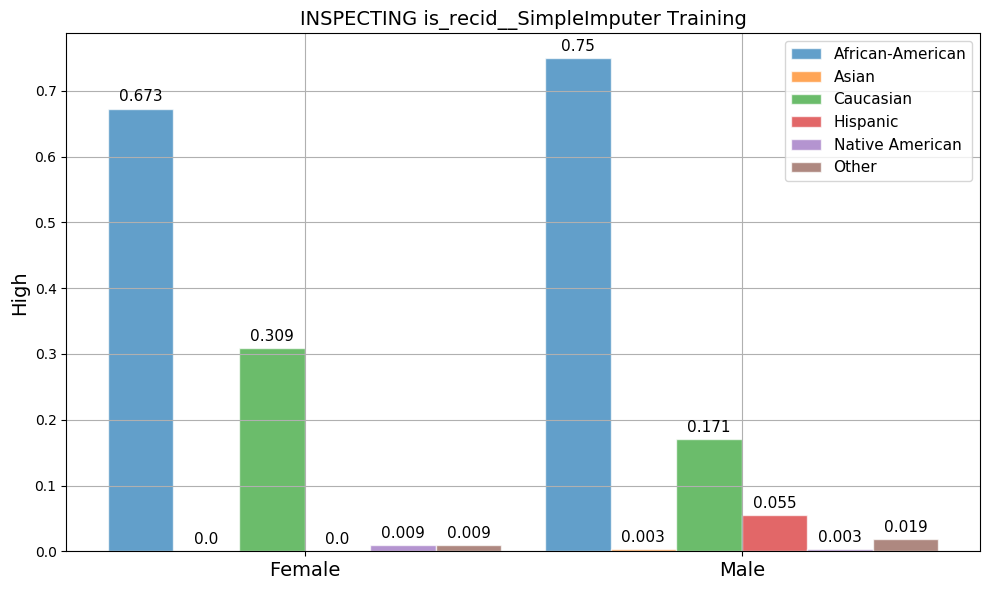

Negative_Lable:


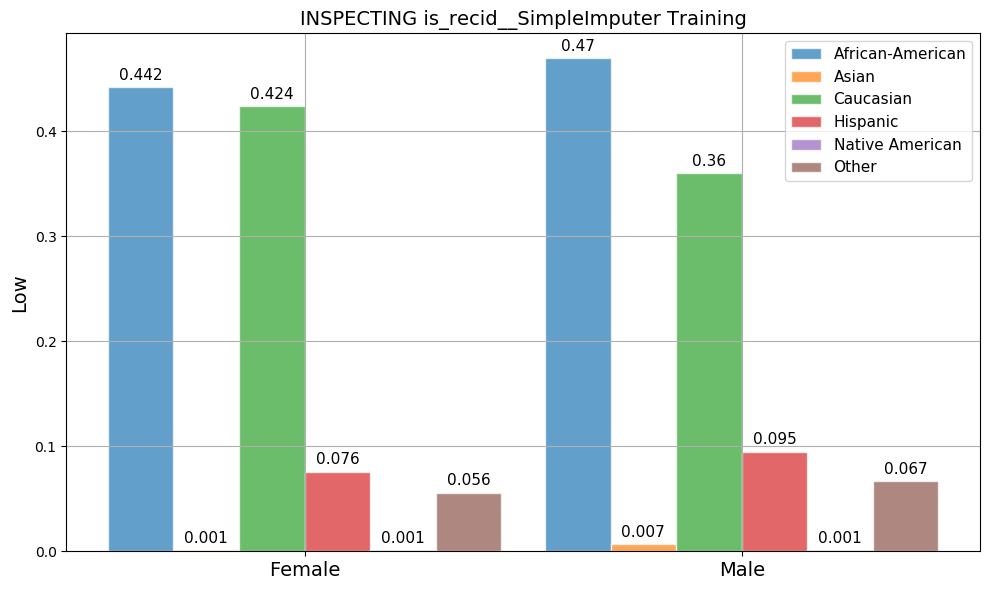

Positive_Lable:


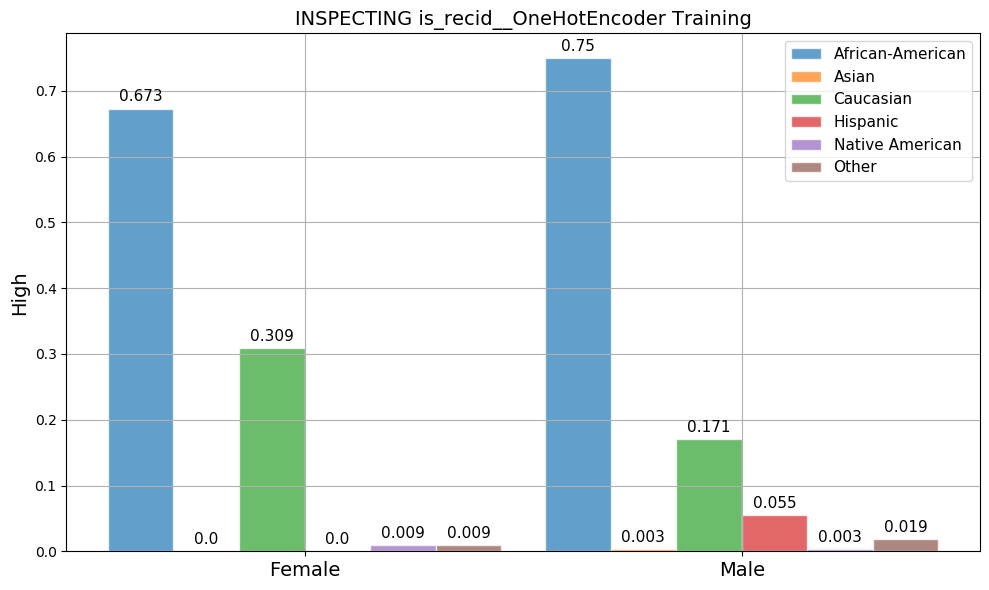

Negative_Lable:


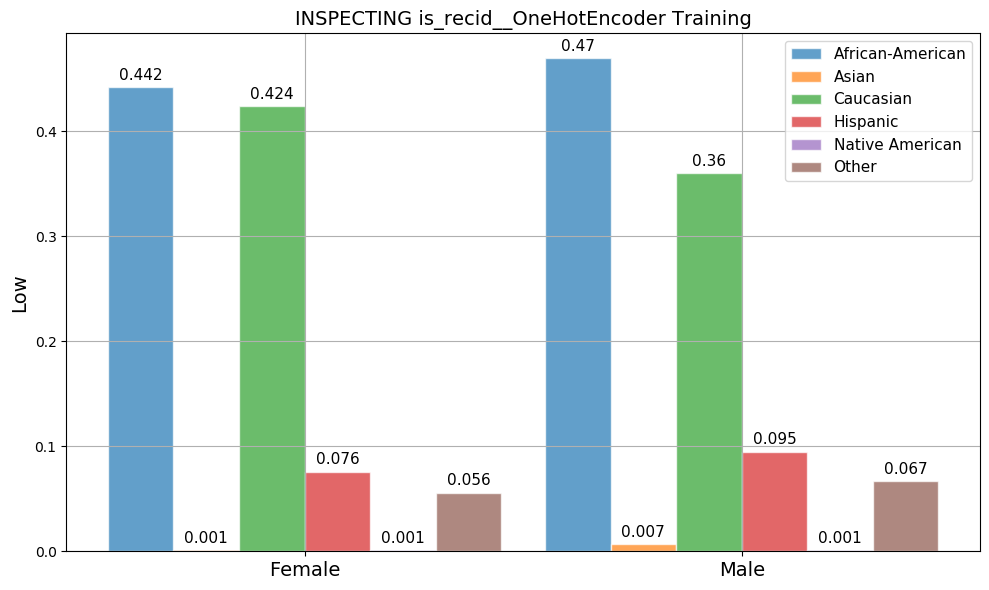

Positive_Lable:


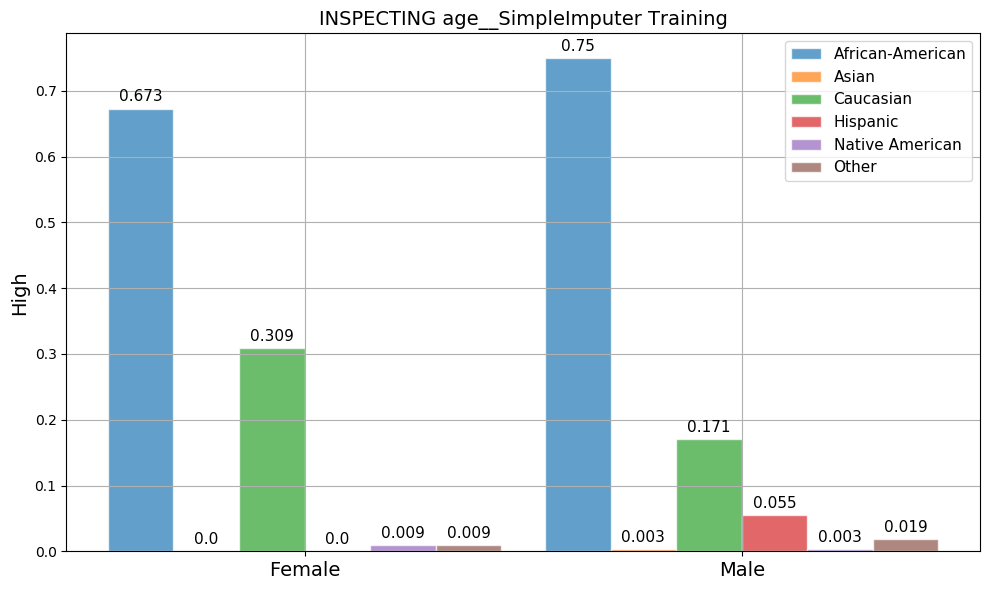

Negative_Lable:


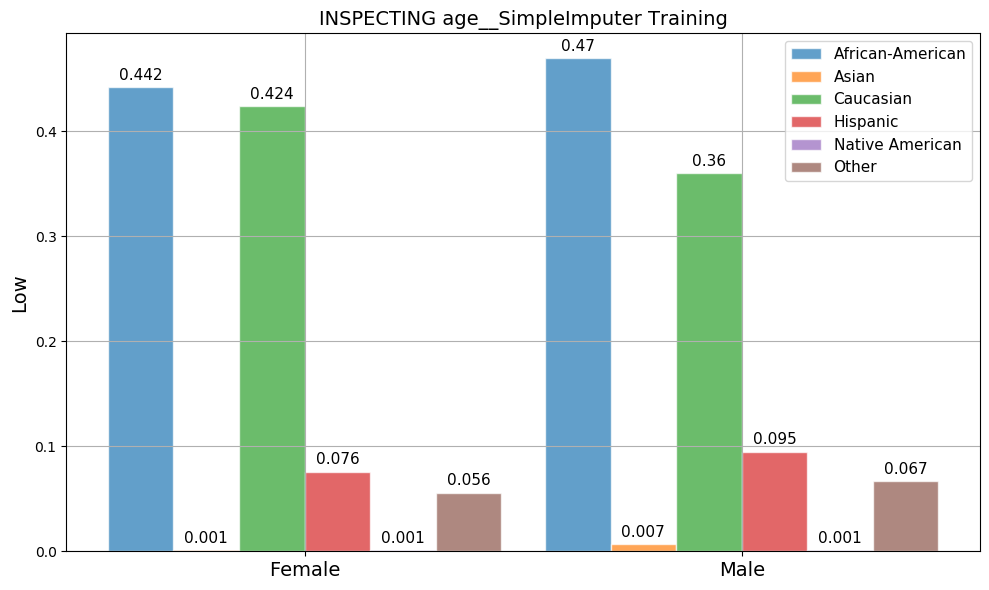

Positive_Lable:


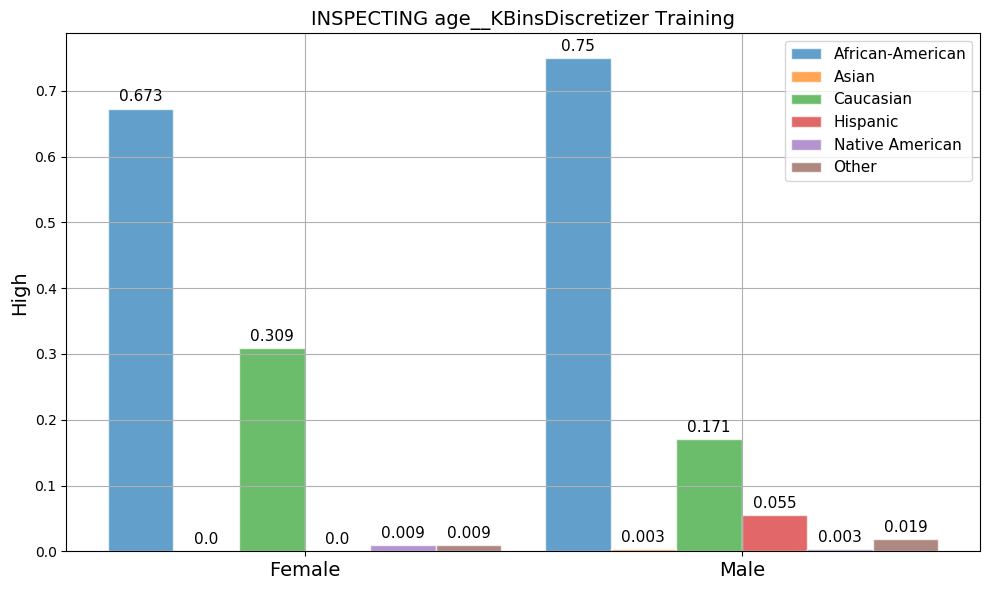

Negative_Lable:


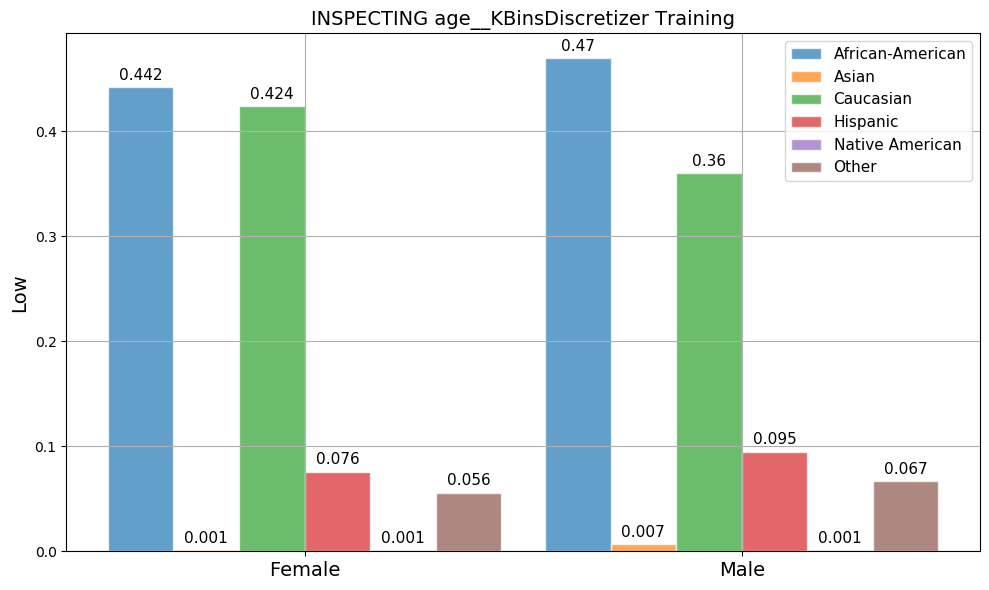

In [12]:
plotly_hist_static_label(pos_group = pos_group, log_list_dag = log_list_dag_train, plot_dict = plot_dict_train, suffix = ' Training', export_images=True, save_path = save_path)


## 4. Generate LOGs

In [13]:
log_static_label(log_list_dag = log_list_dag_train, log_dict = log_dict_train, plot_dict = plot_dict_train)


-------------------------------------------------------------------------------------------
data = pd.read_csv(f_path)
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
data = data[['sex', 'dob','age','c_charge_degree', 'race','score_text','priors_count','days_b_screening_arrest','decile_score','is_recid','two_year_recid','c_jail_in','c_jail_out']]
Changes in STATIC LABEL, show changes in percentage


Female                                                  \
       African-American Asian Caucasian Hispanic Native American  Other   
High              0.002   0.0    -0.004    0.001           0.000  0.000   
Low               0.008   0.0    -0.002   -0.002          -0.002 -0.003   
Medium           -0.013   0.0     0.009    0.002           0.000  0.001   

                   Male                                                   
       African-American  Asian Caucasian Hispanic Native American  Other  
High             -0.001  0.000     0.007   -0.004             0.0 -0.002  
Low               0.001  0.001     0.002   -0.005             0.0  0.002  
Medium           -0.002  0.000     0.006   -0.003             0.0 -0.001

No changes in population

-------------------------------------------------------------------------------------------
data = data.loc[(data['days_b_screening_arrest'] <= 30)]
Changes in STATIC LABEL, show changes in percentage


Female                                                  \
       African-American Asian Caucasian Hispanic Native American  Other   
High             -0.011   0.0     0.009    0.001           0.001  0.001   
Low               0.003   0.0    -0.001    0.002           0.000 -0.004   
Medium            0.000   0.0     0.006   -0.006           0.000  0.002   

                   Male                                                   
       African-American  Asian Caucasian Hispanic Native American  Other  
High              0.003  0.001     0.000   -0.003          -0.001  0.001  
Low              -0.001  0.000     0.002    0.000          -0.001 -0.001  
Medium            0.005  0.000    -0.001   -0.004          -0.001  0.001

 -- TARGET changed in CATEGORICAL features


,missing_count,num_class,class_count,class_percent
race,0.0,0.0,"{'African-American': -221, 'Caucasian': -114, 'Hispanic': -60, 'Other': -19, 'Asian': 0, 'Native American': -5}","{'African-American': -0.0013, 'Caucasian': 0.006, 'Hispanic': -0.0049, 'Other': 0.0006, 'Asian': 0.0004, 'Native American': -0.0008}"



-------------------------------------------------------------------------------------------
data = data.loc[(data['days_b_screening_arrest'] >= -30)]
Changes in STATIC LABEL, show changes in percentage


Female                                                  \
       African-American Asian Caucasian Hispanic Native American  Other   
High              0.023   0.0    -0.007   -0.017             0.0  0.000   
Low              -0.007   0.0     0.004    0.000             0.0  0.003   
Medium            0.003   0.0     0.004   -0.011             0.0  0.003   

                   Male                                                   
       African-American  Asian Caucasian Hispanic Native American  Other  
High              0.009  0.000    -0.011    0.002          -0.001  0.001  
Low               0.004  0.000    -0.004   -0.004           0.001  0.004  
Medium            0.014 -0.001    -0.015    0.001           0.000  0.001

 -- TARGET changed in CATEGORICAL features


,missing_count,num_class,class_count,class_percent
race,0.0,0.0,"{'African-American': -139, 'Caucasian': -131, 'Hispanic': -35, 'Other': -6, 'Asian': -1, 'Native American': -1}","{'African-American': 0.0049, 'Caucasian': -0.0054, 'Hispanic': -0.002, 'Other': 0.0025, 'Asian': 0.0001, 'Native American': -0.0001}"



-------------------------------------------------------------------------------------------
data = data.loc[(data['is_recid'] != -1)]
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
data = data.loc[(data['c_charge_degree'] != "O")]
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
data = data.loc[(data['score_text'] != 'N/A')]
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
data = data.replace('Medium', "Low")
Changes in STATIC LABEL, show changes in percentage


Female                                                   \
       African-American  Asian Caucasian Hispanic Native American  Other   
High              0.000  0.000     0.000    0.000           0.000  0.000   
Low               0.042 -0.001    -0.007   -0.026           0.001 -0.009   
Medium              NaN    NaN       NaN      NaN             NaN    NaN   

                   Male                                                   
       African-American  Asian Caucasian Hispanic Native American  Other  
High               0.00  0.000     0.000     0.00             0.0  0.000  
Low                0.07 -0.001    -0.042    -0.01             0.0 -0.017  
Medium              NaN    NaN       NaN      NaN             NaN    NaN

No changes in population

-------------------------------------------------------------------------------------------
is_recid__SimpleImputer
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
is_recid__OneHotEncoder
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
age__SimpleImputer
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
age__KBinsDiscretizer
No changes in STATIC LABEL
 -- TARGET changed in NUMERICAL features


,count,missing_count,median,mad,range
age,0.0,0.0,-31.0,-10.3782,-62.0


## 5. Plot Performance Label and Static Label for Classifier -- Change label inverse once dataset changes

In [14]:
label_inverse = {0: 'High', 1:'Low'}
target_df_train[target_name].replace(label_inverse, inplace = True)
target_df_train['pred_'+target_name].replace(label_inverse, inplace = True)

target_df_train.to_csv(save_path+'/checkpoints/csv/training/prediction.csv')

### Static Label for Input Target Col

Positive_Lable:


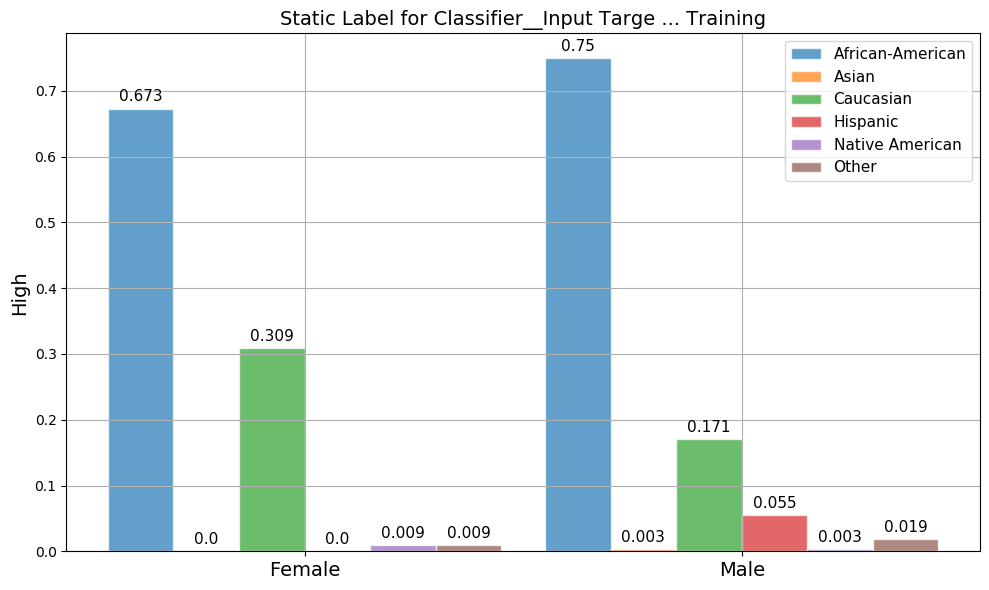

Negative_Lable:


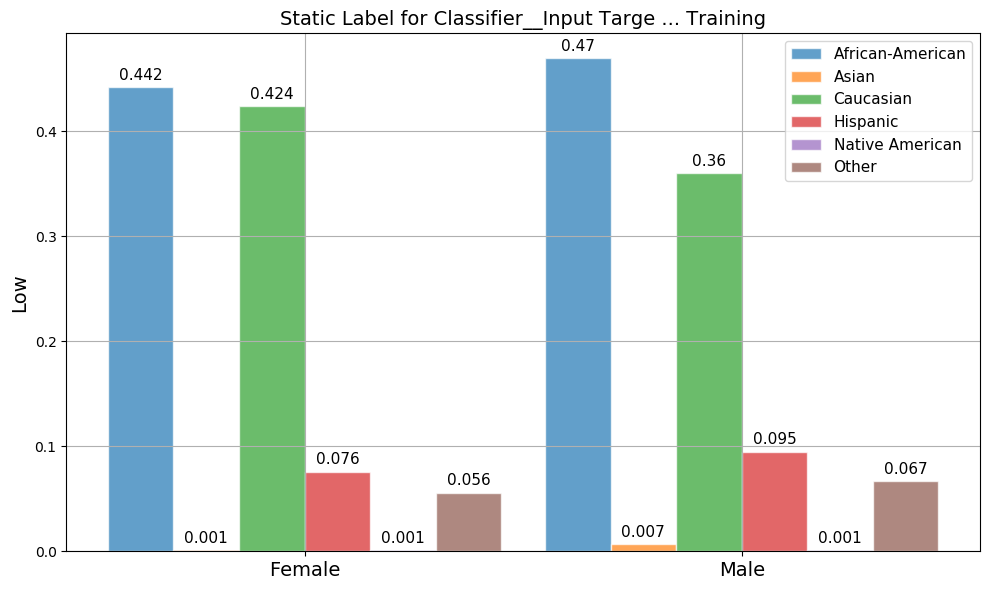

In [15]:
to_plot = static_label(target_df_train, snesi_atts, target_name)
plt_title = 'Static Label for Classifier__Input Target Column'

print("Positive_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 1, suffix = ' Training', export_images = True, save_path = save_path)
print("Negative_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 0, suffix = ' Training', export_images = True, save_path = save_path)


### Static Label for Predicted Target Col

Positive_Lable:


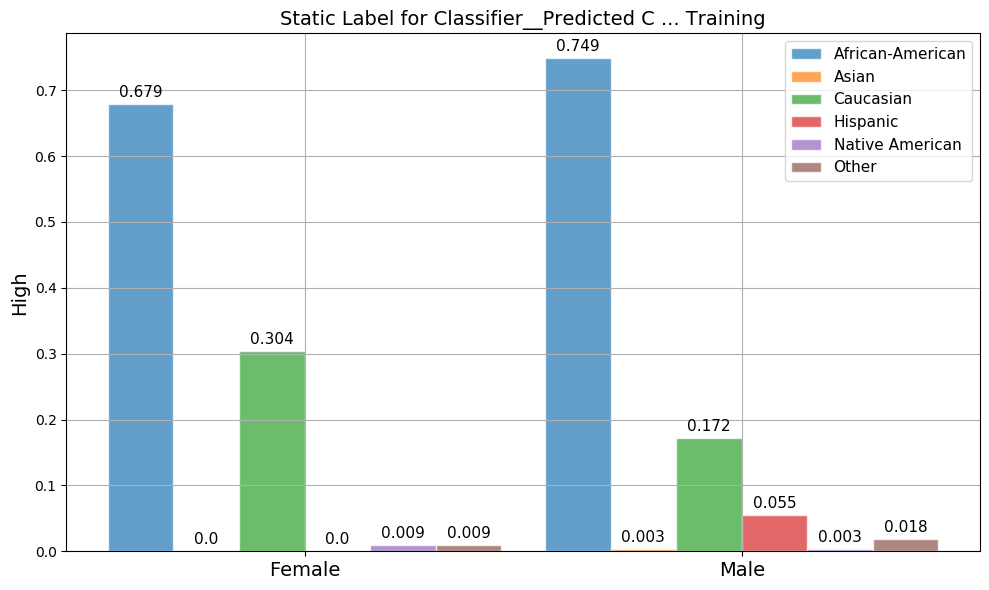

Negative_Lable:


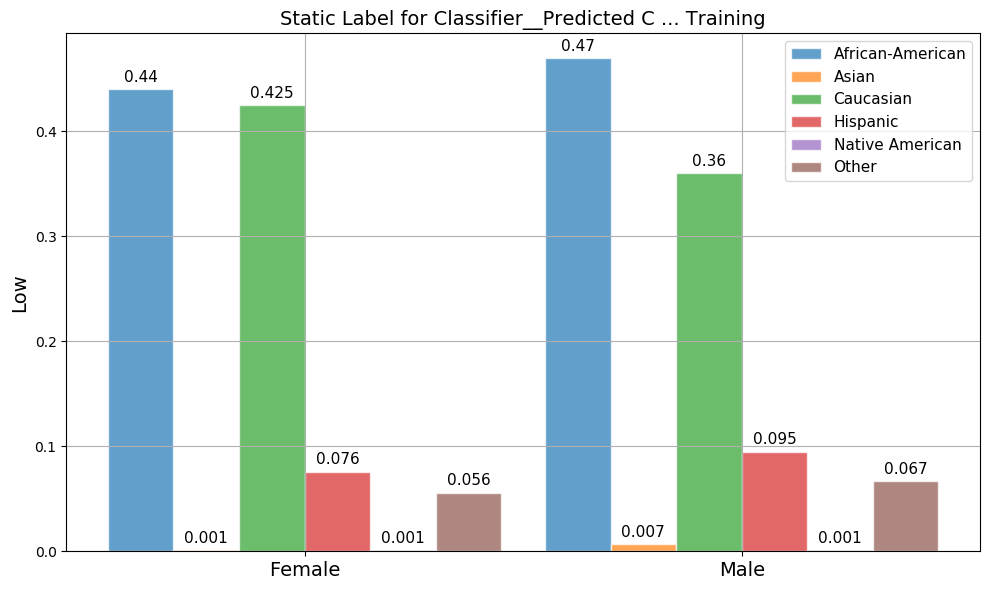

In [16]:
to_plot = static_label(target_df_train, snesi_atts, 'pred_'+target_name)
plt_title = 'Static Label for Classifier__Predicted Column'

print("Positive_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 1, suffix = ' Training', export_images = True, save_path = save_path)
print("Negative_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 0, suffix = ' Training', export_images = True, save_path = save_path)

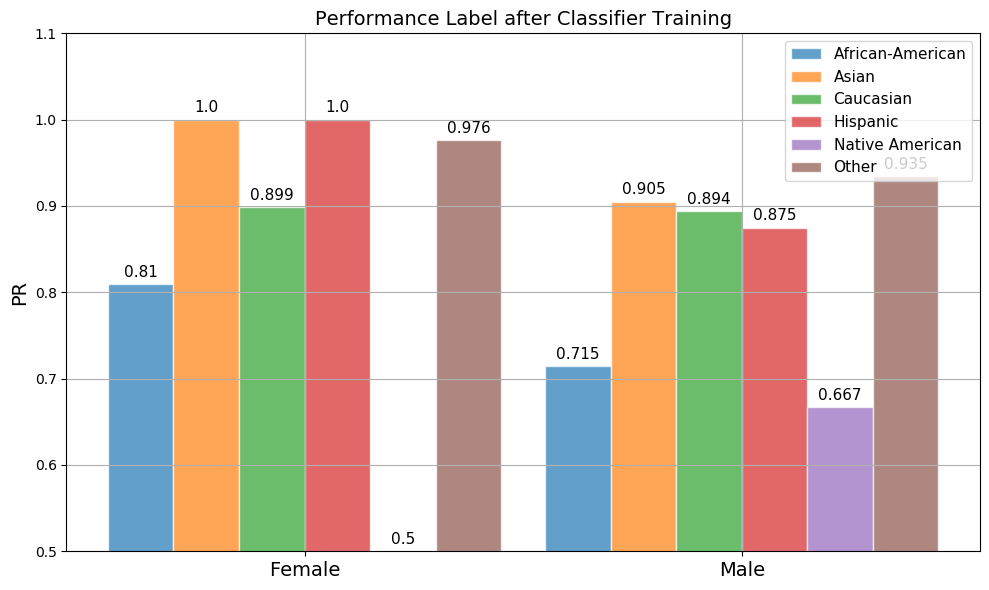

In [17]:
a = get_performance_label(target_df_train, snesi_atts, target_name, pos_group)

draw_bar_plot(a, "PR", snesi_atts, "Performance Label after Classifier Training", False, True, save_path)

# Test Dataset

In [18]:
@tracer(cat_col = ['race'], numerical_col = ['age'], sensi_atts=['sex', 'race'], 
        target_name = "score_text", training = False, save_path = 'case_outputs/compas')
def compas_pipeline(f_path = 'data/compas_test.csv'):

    data = pd.read_csv(f_path)


#     data = data.drop(columns=['age_cat'])


#     data = data.dropna(subset=['id', 'name','is_recid','days_b_screening_arrest','c_charge_degree','c_jail_out','c_jail_in'])


#     data['age_cat'] = data.apply(lambda row:'<25' if row['age'] < 25 else '>45' if row['age']>45 else '25-45', axis=1)


    data = data[['sex', 'dob','age','c_charge_degree', 'race','score_text','priors_count','days_b_screening_arrest',
                 'decile_score','is_recid','two_year_recid','c_jail_in','c_jail_out']]


    data = data.loc[(data['days_b_screening_arrest'] <= 30)]
    data = data.loc[(data['days_b_screening_arrest'] >= -30)]
    data = data.loc[(data['is_recid'] != -1)]
    data = data.loc[(data['c_charge_degree'] != "O")]
    data = data.loc[(data['score_text'] != 'N/A')]
#     data['c_jail_out'] = pd.to_datetime(data['c_jail_out'])
#     data['c_jail_in'] = pd.to_datetime(data['c_jail_in'])
    
    data = data.replace('Medium', "Low")
    
    labels = LabelEncoder().fit_transform(data['score_text'])
    
    #sklearn pipeline
    impute1_and_onehot = Pipeline([('imputer1', SimpleImputer(strategy='most_frequent')),
                                   ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    impute2_and_bin = Pipeline([('imputer2', SimpleImputer(strategy='mean')),
                                ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform'))])
    featurizer = ColumnTransformer(transformers=[
            ('impute1_and_onehot', impute1_and_onehot, ['is_recid']),
            ('impute2_and_bin', impute2_and_bin, ['age'])
        ])

    pipeline = Pipeline([
        ('features', featurizer),
        ('classifier', LogisticRegression())
    ])
    return pipeline

In [19]:
pipeline = compas_pipeline('data/compas_test.csv')
save_path = 'case_outputs/compas'

In [20]:
log_dict_test = pickle.load(open(save_path+"/checkpoints/log_dict_test.p", 'rb'))

rand_rgb_test = pickle.load(open(save_path+"/checkpoints/rand_color_test.p", 'rb'))

plot_dict_test = pickle.load(open(save_path+"/checkpoints/plot_dict_test.p", 'rb'))

log_list_dag_test = pickle.load(open(save_path+"/checkpoints/log_list_dag_test.p", 'rb'))

target_df_test = pickle.load(open(save_path+"/checkpoints/target_df_test.p", 'rb'))

clf = pickle.load(open(save_path+"/checkpoints/clf.p", 'rb'))

Positive_Lable:


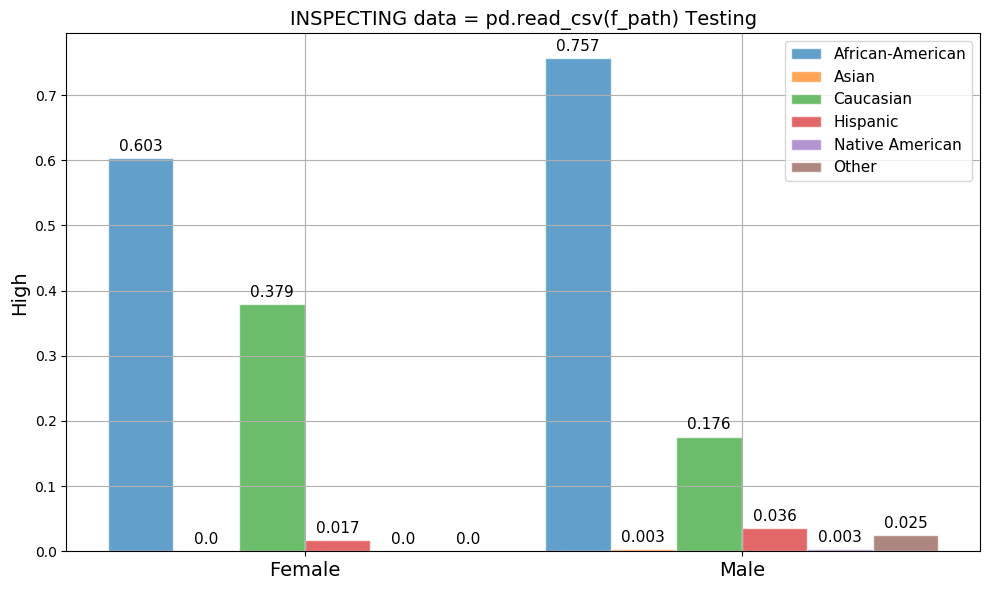

Negative_Lable:


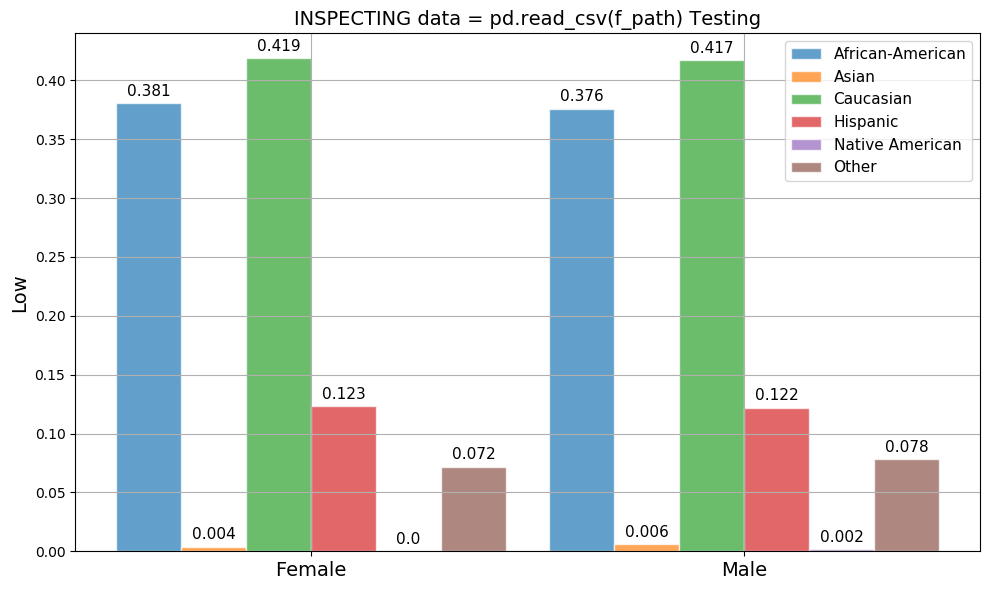

Positive_Lable:


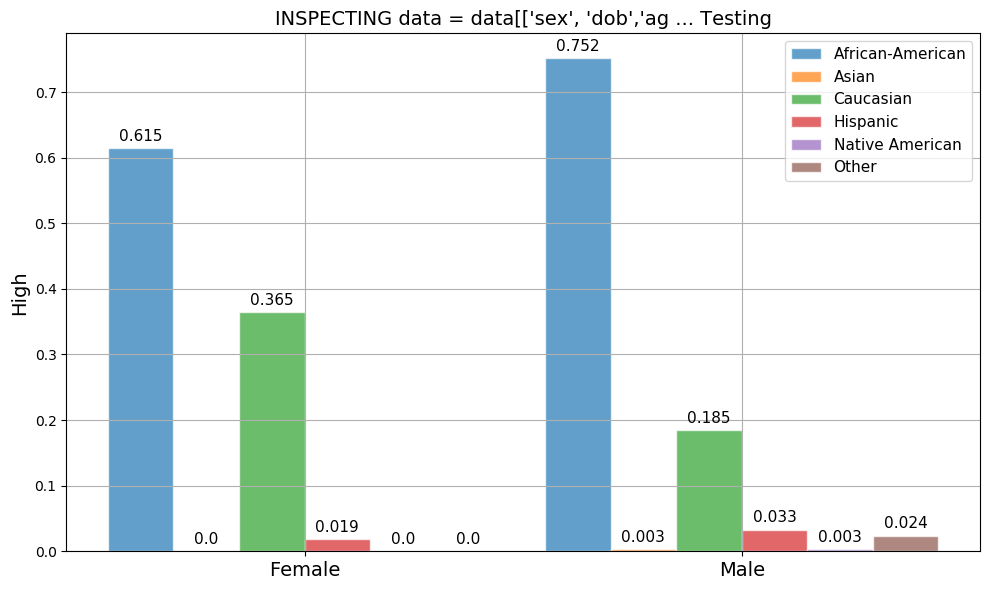

Negative_Lable:


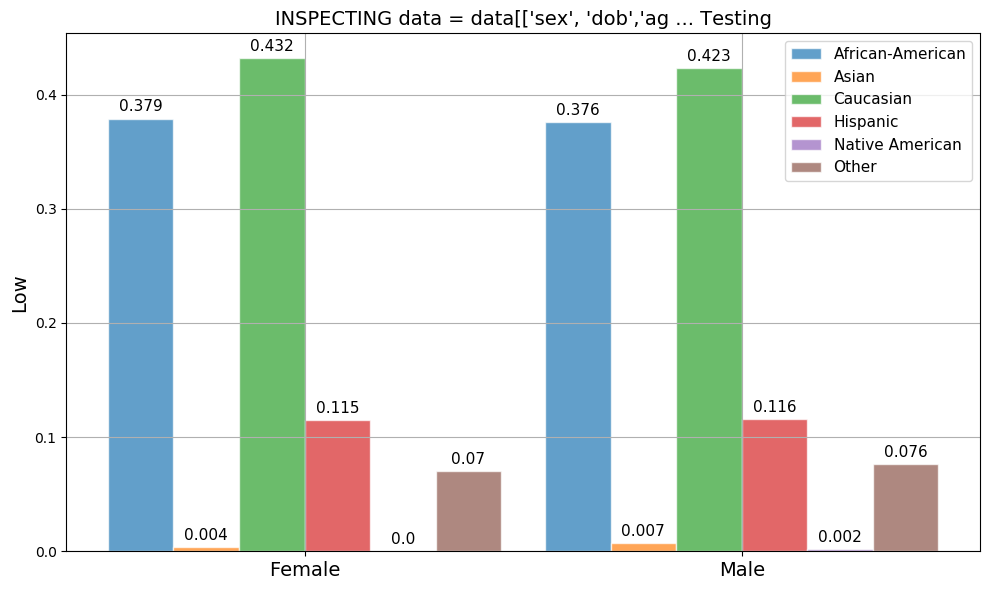

Positive_Lable:


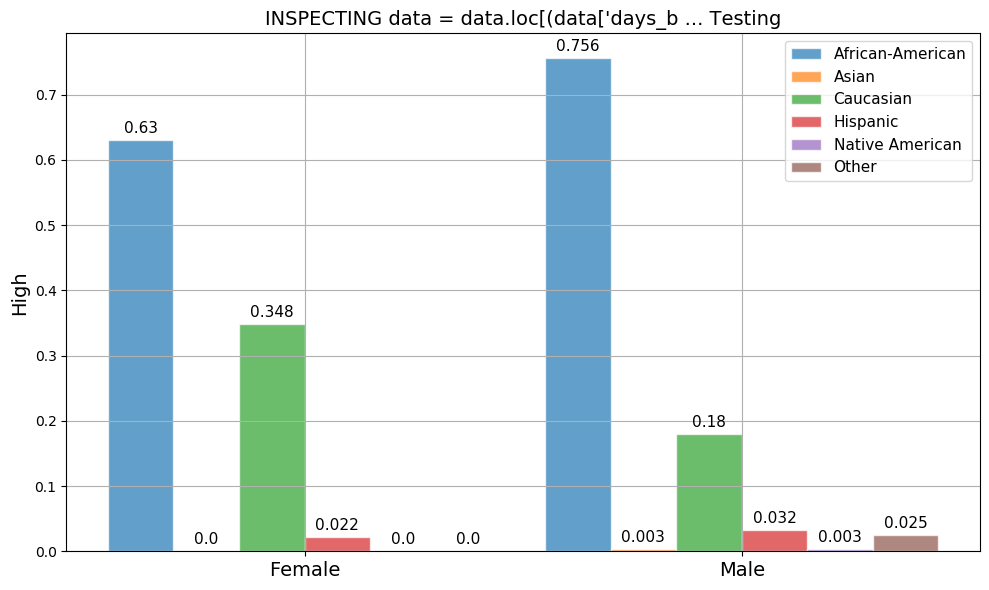

Negative_Lable:


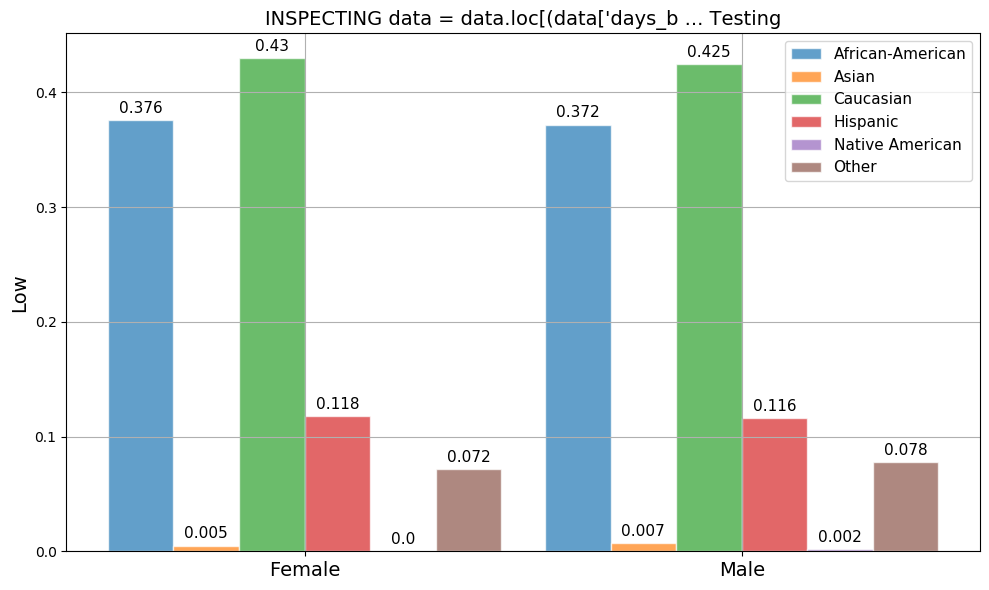

Positive_Lable:


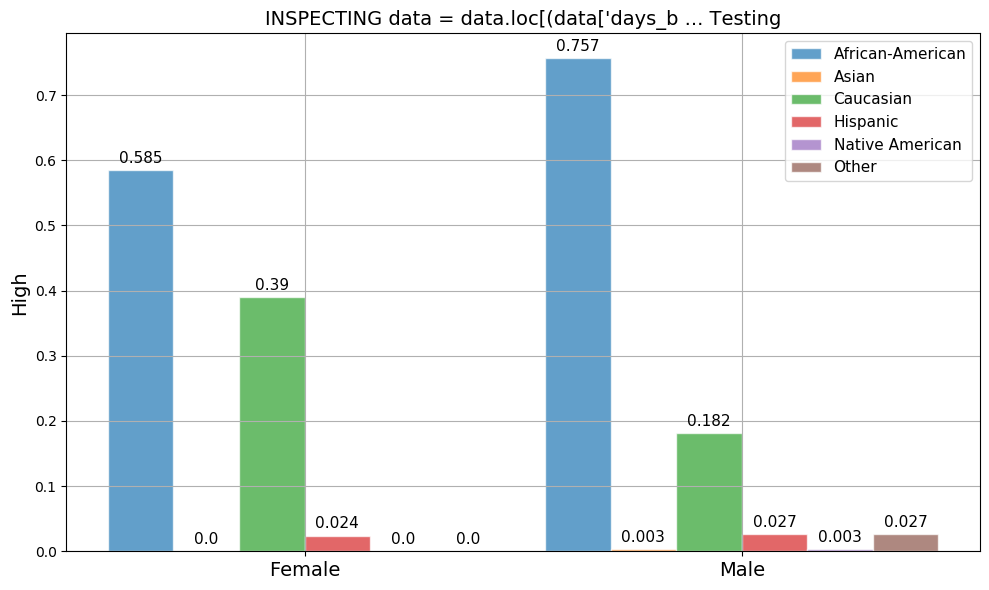

Negative_Lable:


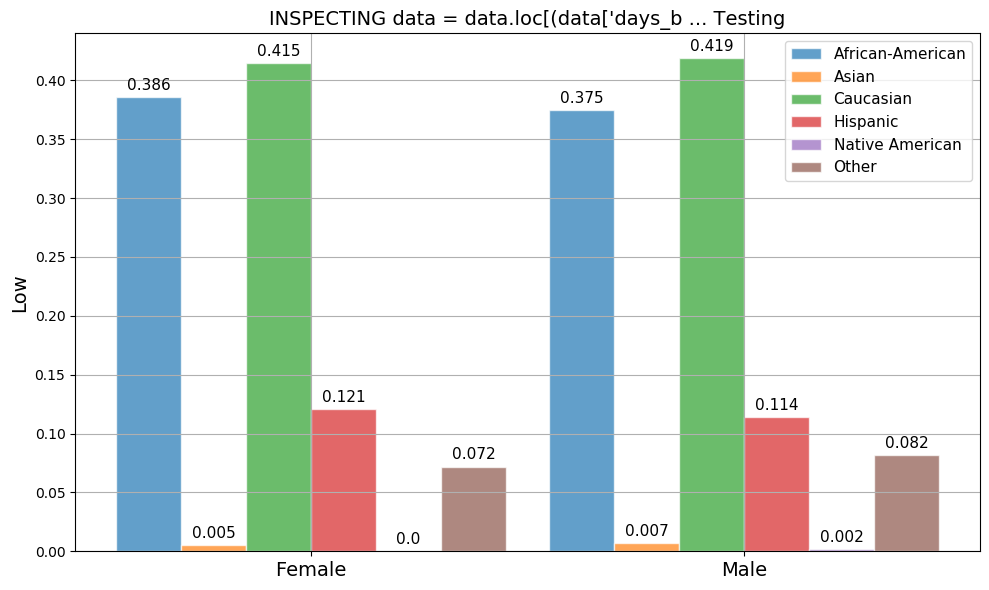

Positive_Lable:


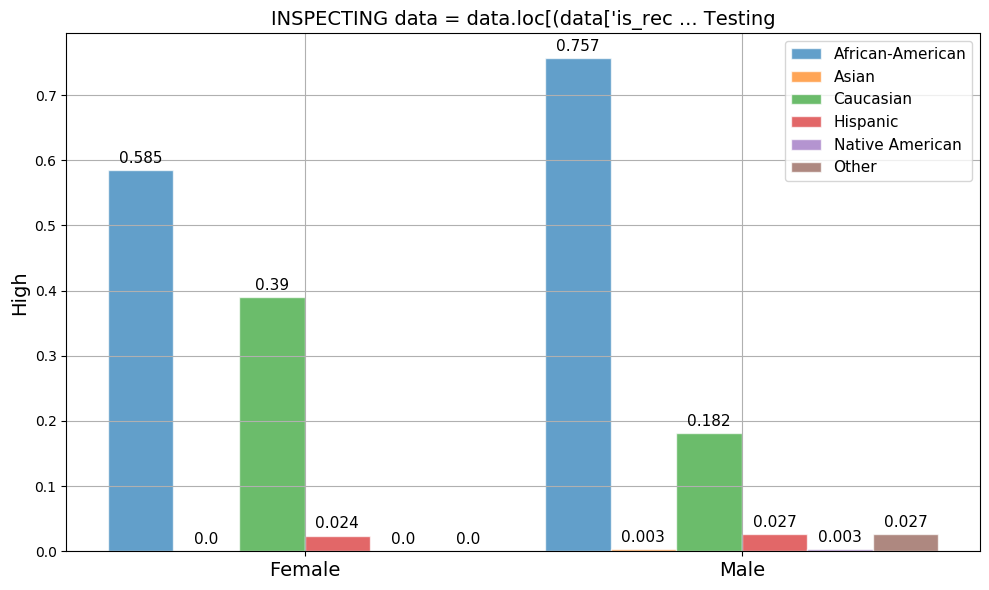

Negative_Lable:


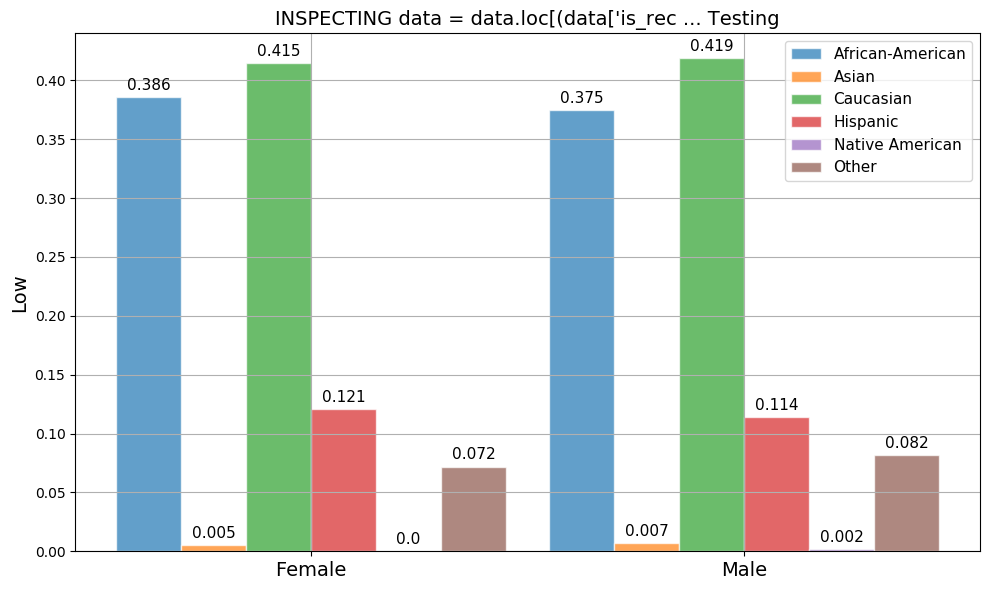

Positive_Lable:


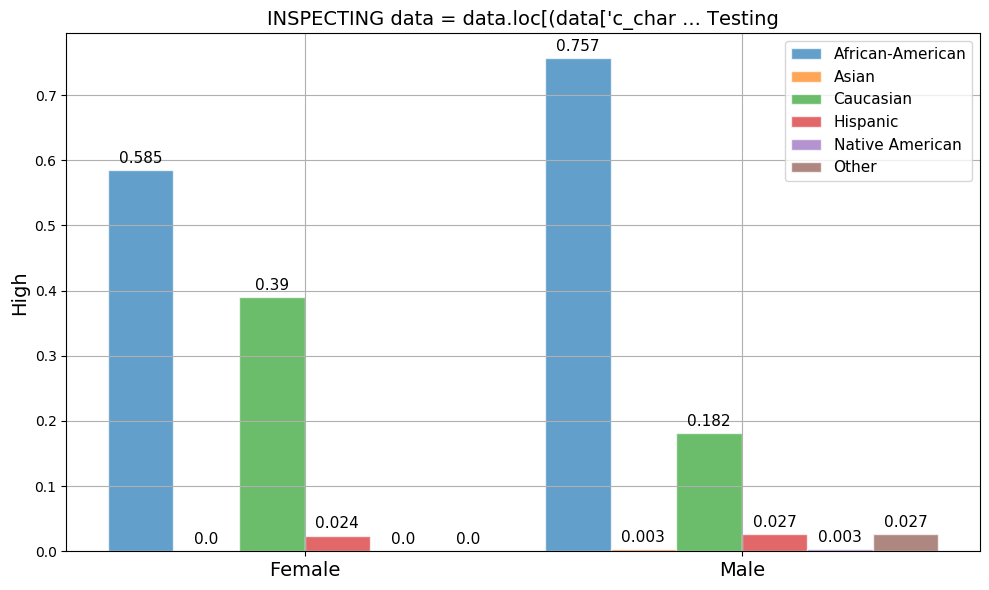

Negative_Lable:


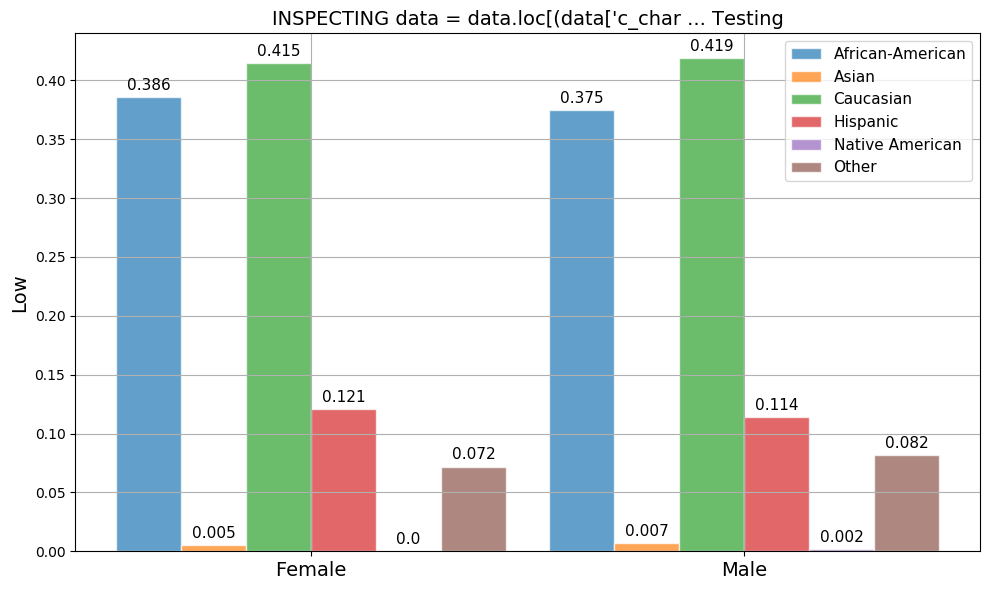

Positive_Lable:


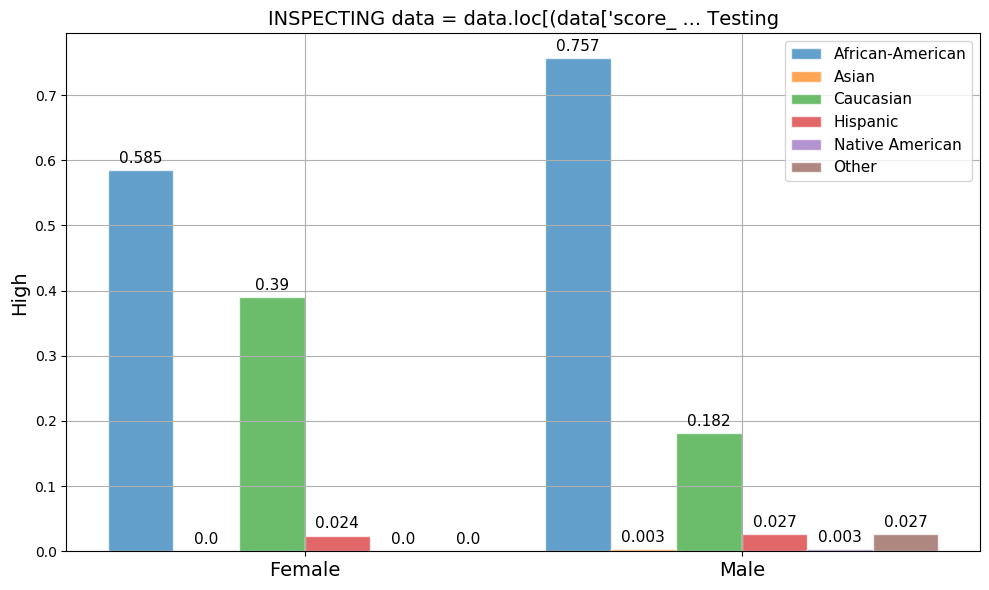

Negative_Lable:


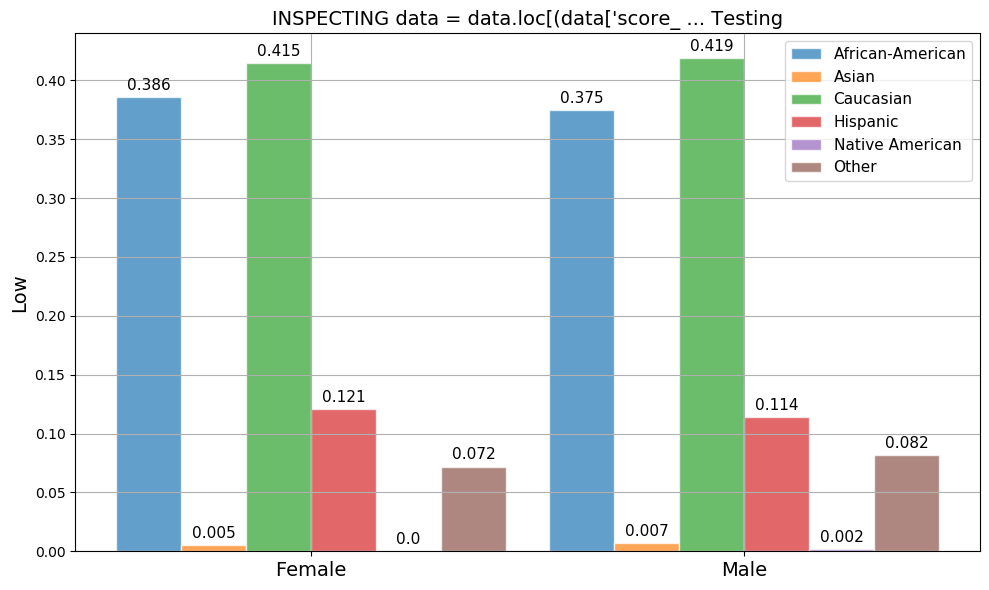

Positive_Lable:


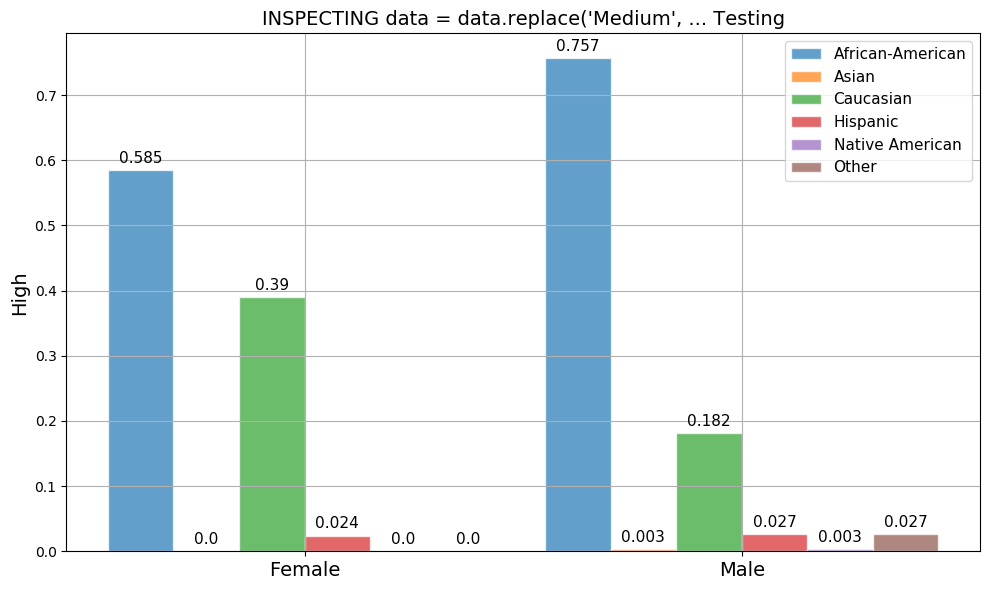

Negative_Lable:


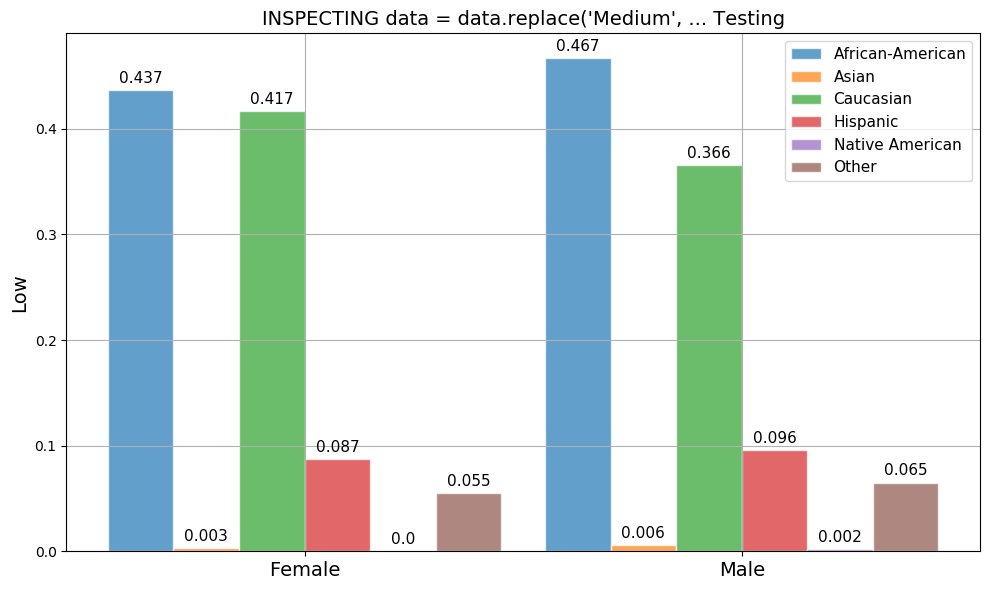

Positive_Lable:


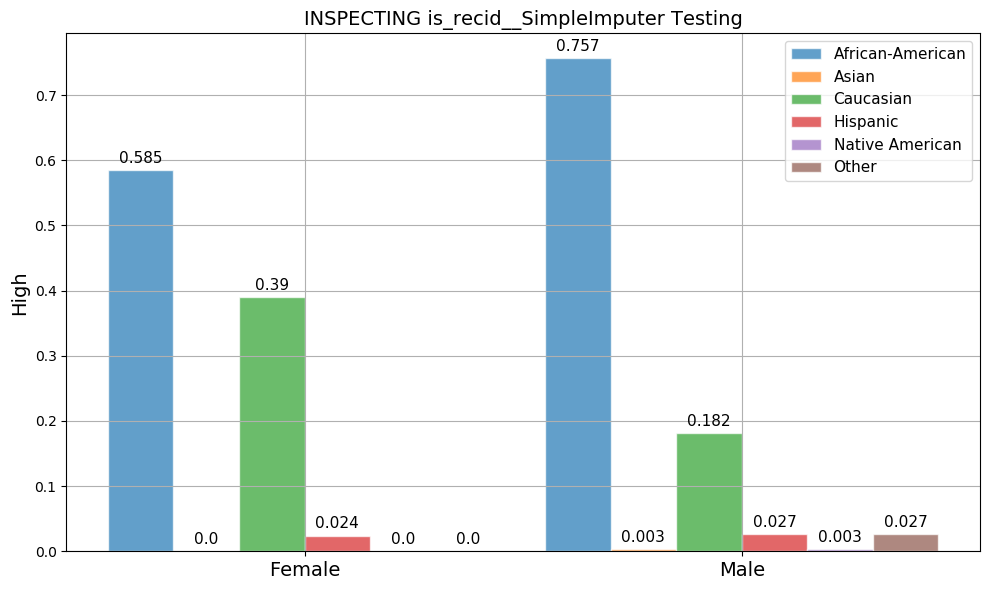

Negative_Lable:


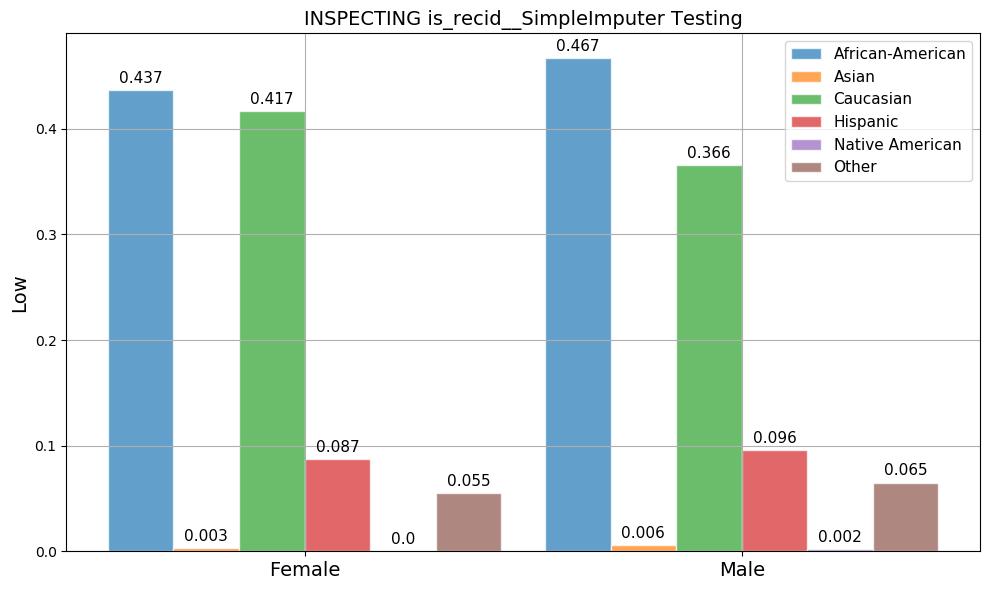

Positive_Lable:


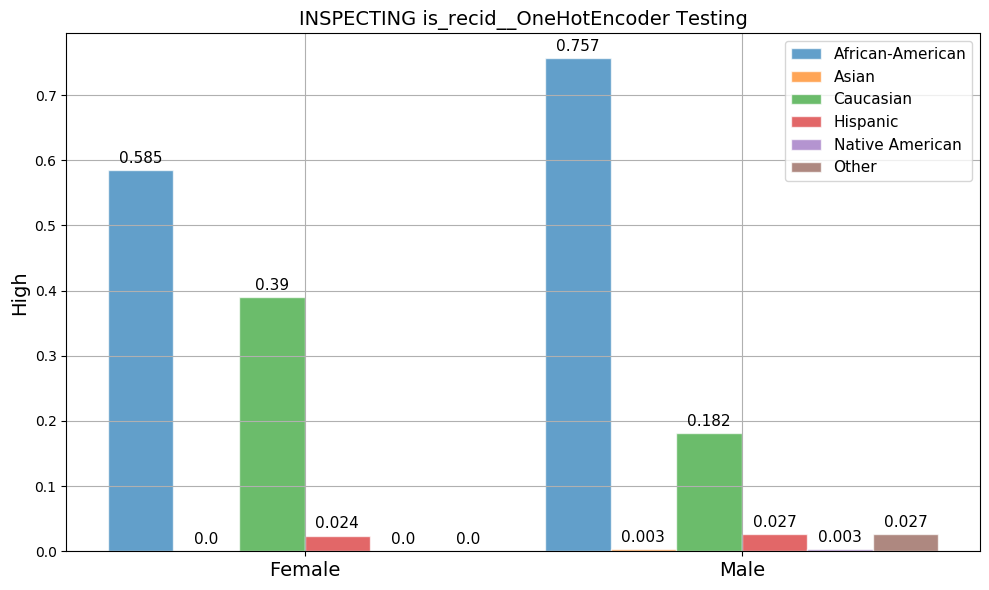

Negative_Lable:


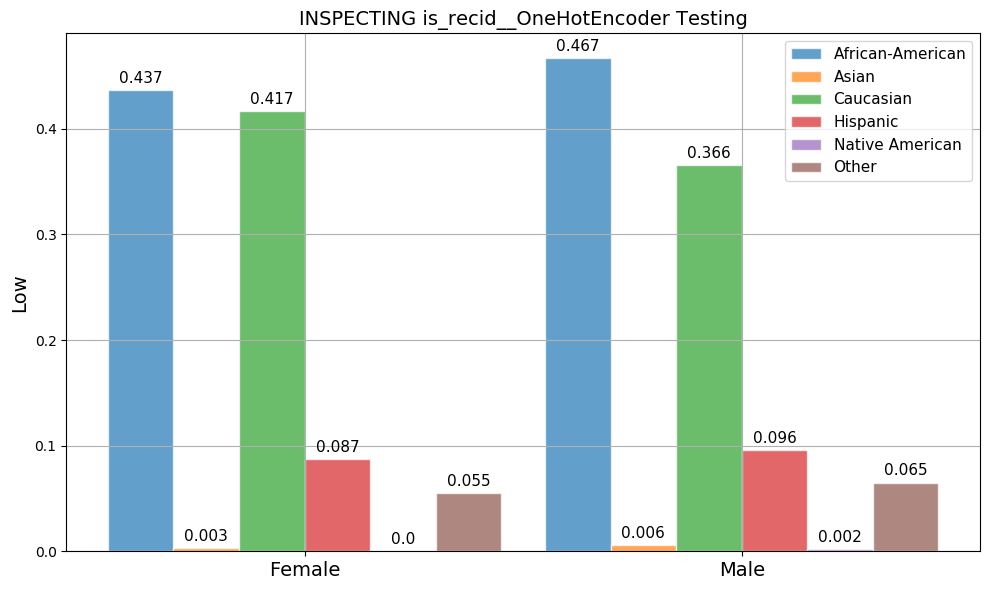

Positive_Lable:


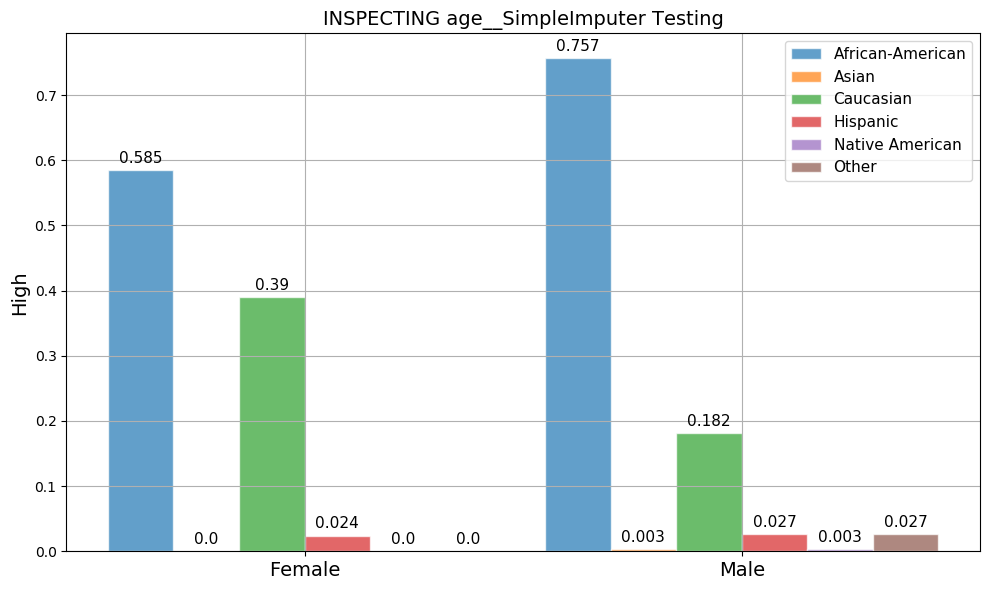

Negative_Lable:


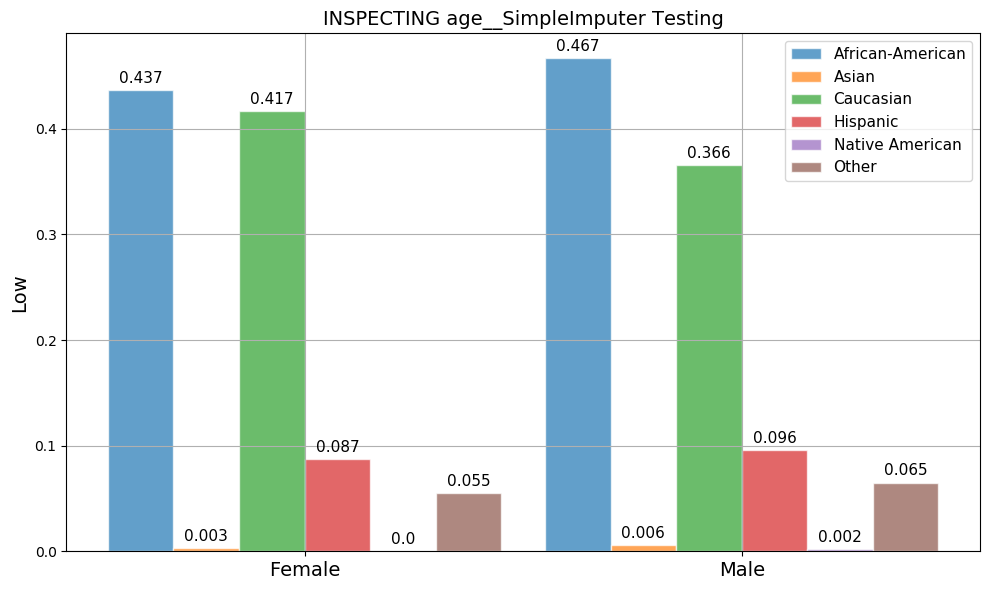

Positive_Lable:


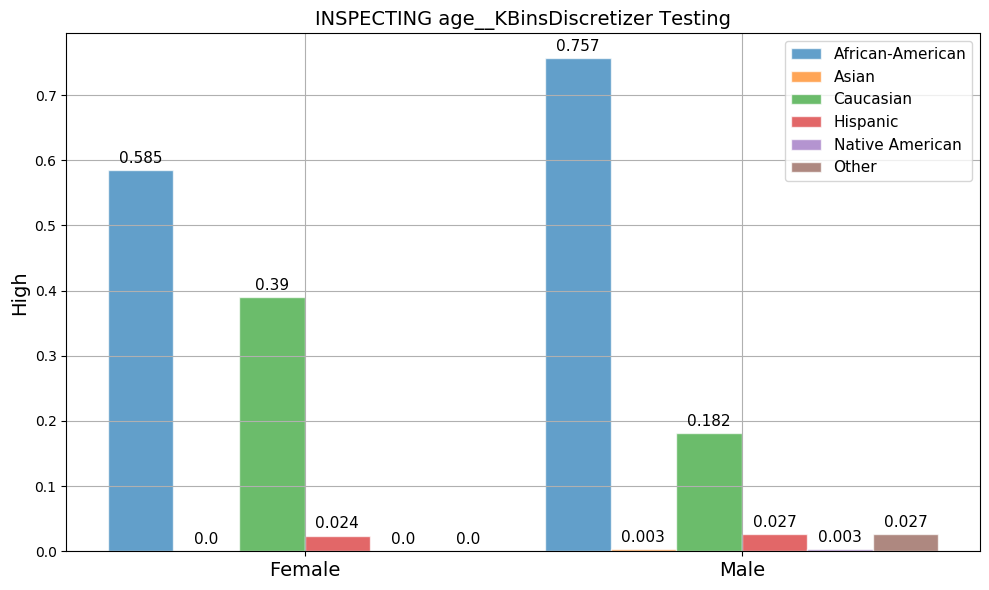

Negative_Lable:


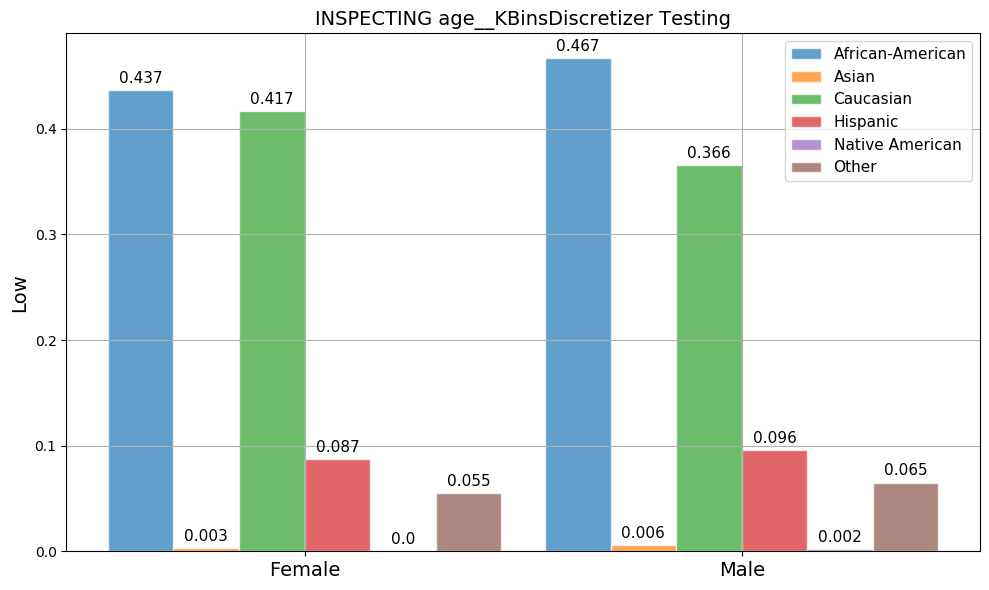

In [21]:
plotly_hist_static_label(pos_group = pos_group, log_list_dag = log_list_dag_test, plot_dict = plot_dict_test, suffix = ' Testing', export_images=True, save_path = save_path)


In [22]:
log_static_label(log_list_dag = log_list_dag_test, log_dict = log_dict_test, plot_dict = plot_dict_test)


-------------------------------------------------------------------------------------------
data = pd.read_csv(f_path)
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
data = data[['sex', 'dob','age','c_charge_degree', 'race','score_text','priors_count','days_b_screening_arrest','decile_score','is_recid','two_year_recid','c_jail_in','c_jail_out']]
Changes in STATIC LABEL, show changes in percentage


Female                                                  \
       African-American Asian Caucasian Hispanic Native American  Other   
High              0.012   0.0    -0.014    0.002             0.0  0.000   
Low              -0.002   0.0     0.013   -0.008             0.0 -0.002   
Medium           -0.003   0.0     0.000    0.001             0.0  0.001   

                   Male                                                   
       African-American  Asian Caucasian Hispanic Native American  Other  
High             -0.005  0.000     0.009   -0.003             0.0 -0.001  
Low               0.000  0.001     0.006   -0.006             0.0 -0.002  
Medium            0.000  0.000     0.002    0.000             0.0 -0.001

No changes in population

-------------------------------------------------------------------------------------------
data = data.loc[(data['days_b_screening_arrest'] <= 30)]
Changes in STATIC LABEL, show changes in percentage


Female                                                   \
       African-American  Asian Caucasian Hispanic Native American  Other   
High              0.015  0.000    -0.017    0.003           0.000  0.000   
Low              -0.003  0.001    -0.002    0.003           0.000  0.002   
Medium            0.005  0.000    -0.008    0.002           0.001  0.001   

                   Male                                                  
       African-American Asian Caucasian Hispanic Native American  Other  
High              0.004   0.0    -0.005   -0.001             0.0  0.001  
Low              -0.004   0.0     0.002    0.000             0.0  0.002  
Medium            0.005   0.0    -0.006    0.000             0.0  0.001

 -- TARGET changed in CATEGORICAL features


,missing_count,num_class,class_count,class_percent
race,0.0,0.0,"{'African-American': -96, 'Caucasian': -49, 'Hispanic': -20, 'Other': -7, 'Asian': 0, 'Native American': 0}","{'African-American': -0.004, 'Caucasian': 0.0052, 'Hispanic': -0.0027, 'Other': 0.001, 'Asian': 0.0004, 'Native American': 0.0002}"



-------------------------------------------------------------------------------------------
data = data.loc[(data['days_b_screening_arrest'] >= -30)]
Changes in STATIC LABEL, show changes in percentage


Female                                                  \
       African-American Asian Caucasian Hispanic Native American  Other   
High             -0.045   0.0     0.042    0.002           0.000  0.000   
Low               0.010   0.0    -0.015    0.003           0.000  0.000   
Medium            0.018   0.0     0.003   -0.014          -0.009  0.003   

                   Male                                                   
       African-American  Asian Caucasian Hispanic Native American  Other  
High              0.001  0.000     0.002   -0.005             0.0  0.002  
Low               0.003  0.000    -0.006   -0.002             0.0  0.004  
Medium            0.004  0.001    -0.008    0.002             0.0  0.002

 -- TARGET changed in CATEGORICAL features


,missing_count,num_class,class_count,class_percent
race,0.0,0.0,"{'African-American': -65, 'Caucasian': -57, 'Hispanic': -13, 'Other': -2, 'Asian': 0, 'Native American': -1}","{'African-American': 0.0027, 'Caucasian': -0.0047, 'Hispanic': -0.0008, 'Other': 0.0028, 'Asian': 0.0003, 'Native American': -0.0004}"



-------------------------------------------------------------------------------------------
data = data.loc[(data['is_recid'] != -1)]
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
data = data.loc[(data['c_charge_degree'] != "O")]
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
data = data.loc[(data['score_text'] != 'N/A')]
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
data = data.replace('Medium', "Low")
Changes in STATIC LABEL, show changes in percentage


Female                                                   \
       African-American  Asian Caucasian Hispanic Native American  Other   
High              0.000  0.000     0.000    0.000             0.0  0.000   
Low               0.051 -0.002     0.002   -0.034             0.0 -0.017   
Medium              NaN    NaN       NaN      NaN             NaN    NaN   

                   Male                                                   
       African-American  Asian Caucasian Hispanic Native American  Other  
High              0.000  0.000     0.000    0.000             0.0  0.000  
Low               0.092 -0.001    -0.053   -0.018             0.0 -0.017  
Medium              NaN    NaN       NaN      NaN             NaN    NaN

No changes in population

-------------------------------------------------------------------------------------------
is_recid__SimpleImputer
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
is_recid__OneHotEncoder
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
age__SimpleImputer
No changes in STATIC LABEL
No changes in population

-------------------------------------------------------------------------------------------
age__KBinsDiscretizer
No changes in STATIC LABEL
 -- TARGET changed in NUMERICAL features


,count,missing_count,median,mad,range
age,0.0,0.0,-31.0,-10.3782,-74.0


### Do Training

In [23]:
to_train = target_df_train.drop([target_name], axis=1).select_dtypes(include=['int', 'float64'])
to_test = target_df_test.drop([target_name], axis=1).select_dtypes(include=['int', 'float64'])

clf.fit(to_train, target_df_train[target_name])
target_df_test['pred_'+target_name] = clf.predict(to_test)

### Generate Labels -- Change label inverse once dataset changes

In [24]:
label_inverse = {0: 'High', 1:'Low'}
target_df_test[target_name].replace(label_inverse, inplace = True)
target_df_test['pred_'+target_name].replace(label_inverse, inplace = True)

target_df_test.to_csv(save_path+'/checkpoints/csv/testing/prediction.csv')

Positive_Lable:


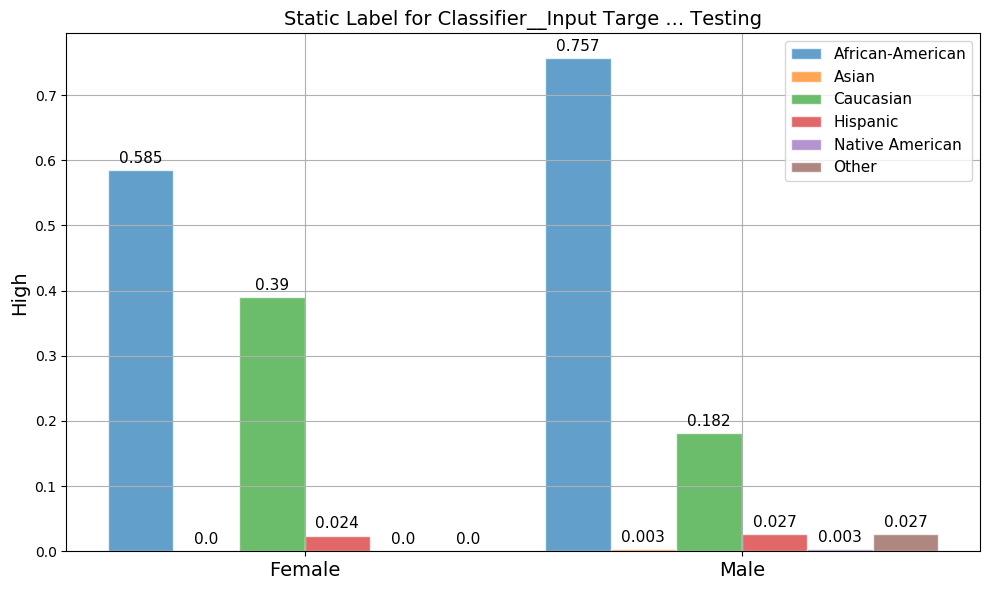

Negative_Lable:


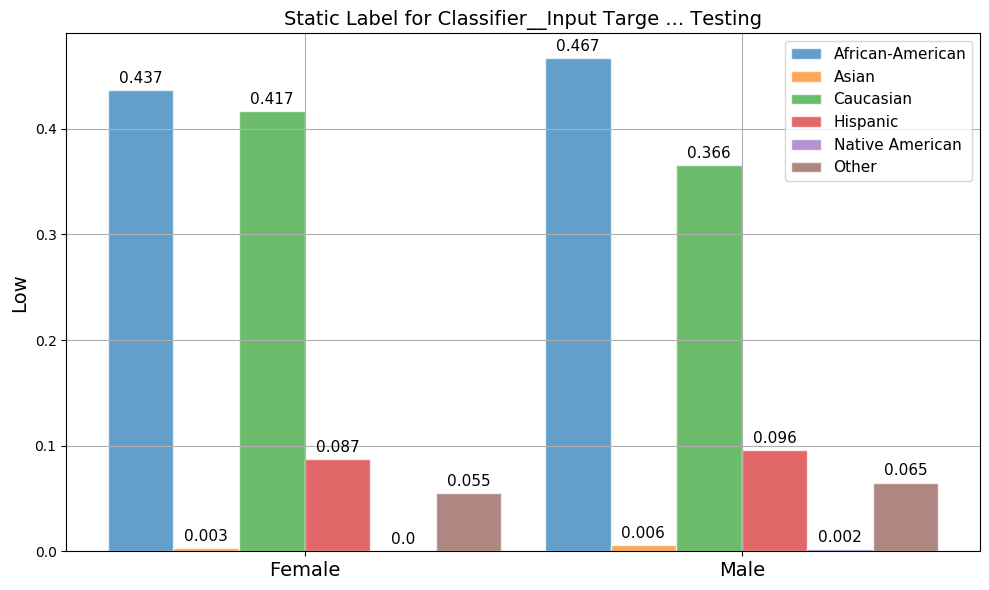

In [25]:
to_plot = static_label(target_df_test, snesi_atts, target_name)
plt_title = 'Static Label for Classifier__Input Target Column'

print("Positive_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 1, suffix = ' Testing', export_images = True, save_path = save_path)
print("Negative_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 0, suffix = ' Testing', export_images = True, save_path = save_path)

Positive_Lable:


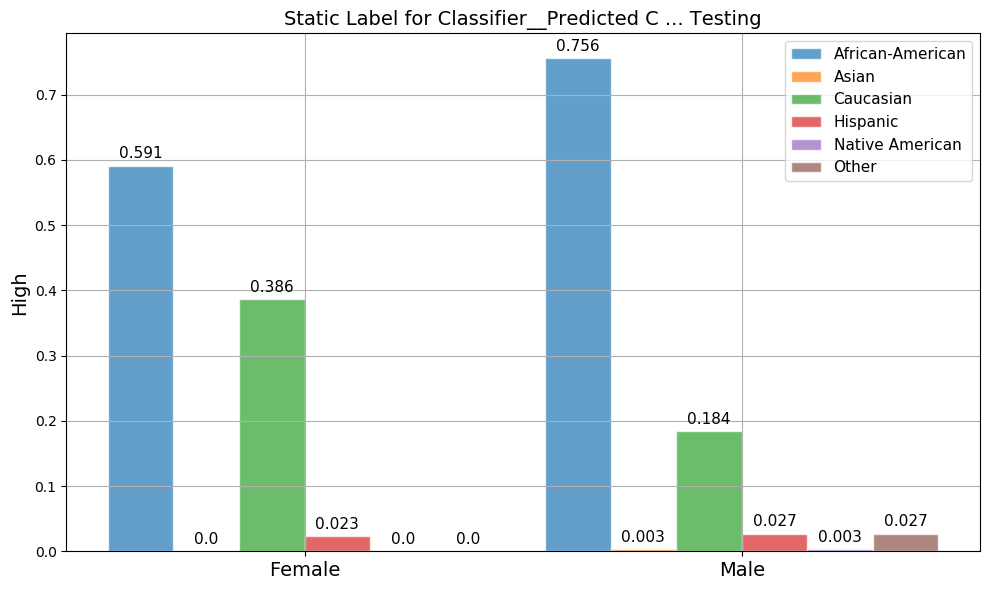

Negative_Lable:


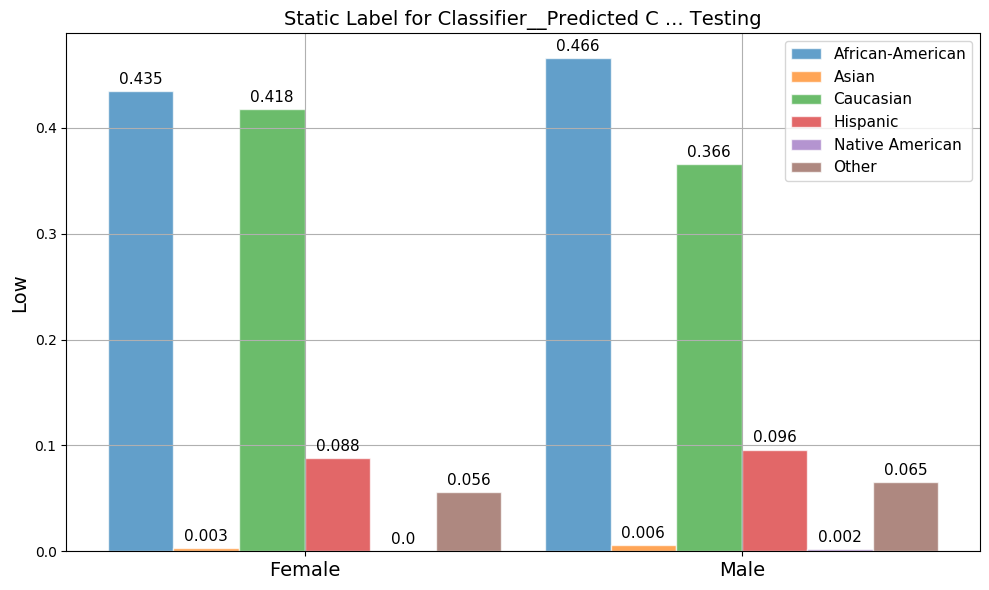

In [26]:
to_plot = static_label(target_df_test, snesi_atts, 'pred_'+target_name)
plt_title = 'Static Label for Classifier__Predicted Column'

print("Positive_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 1, suffix = ' Testing', export_images = True, save_path = save_path)
print("Negative_Lable:")
matplotlib_histogram(to_plot, plt_title, pos_group, show_pos = 0, suffix = ' Testing', export_images = True, save_path = save_path)

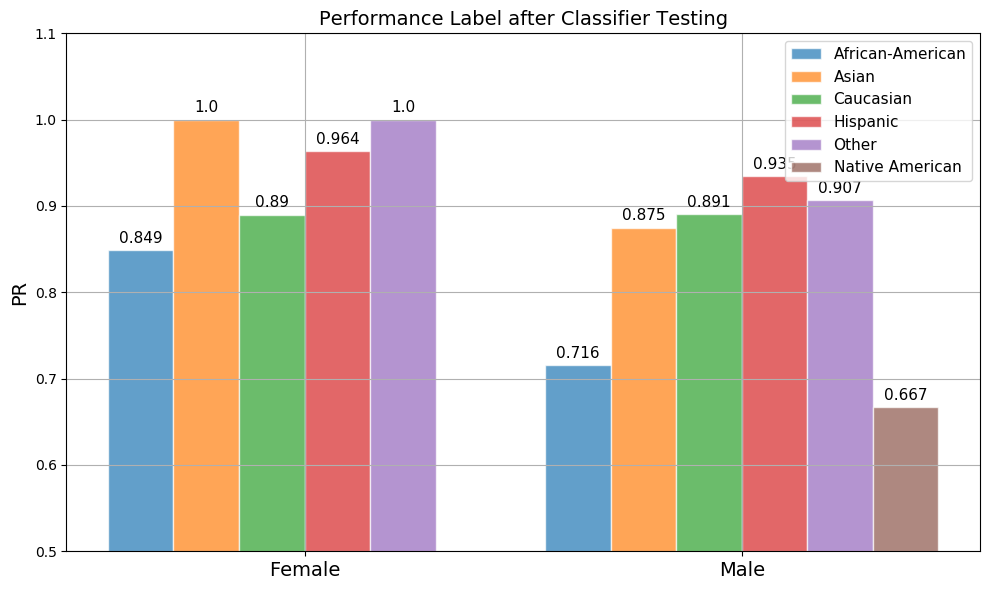

In [27]:

a = get_performance_label(target_df_test, snesi_atts, target_name, pos_group)

draw_bar_plot(a, "PR", snesi_atts, "Performance Label after Classifier Testing", False, True, save_path)